In [1]:
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import time

In [3]:
from scipy.ndimage import convolve

In [4]:
import sympy as sp

# Class

In [5]:
def metric_inversor(g):
    return None

In [6]:
def get_tetrahed(metric):
    
    #The tetrahed is defined as in https://arxiv.org/abs/2404.03095 
    #(there is actually a mistake in the paper but not their code, the version here is correct)

    """
    Constructs a tetrad (orthonormal basis) for a given metric based on the formalism outlined in the referenced paper 
    (https://arxiv.org/abs/2404.03095).

    Parameters:
    -----------
    metric : np.array of shape (4,4,N,N,N,N)

    Returns:
    --------
    np.array (E_0, E_1, E_2, E_3, E_solution)
        - E_0 : shape (4,N,N,N,N)
            The first vector of the tetrad, representing a time-like or null direction.
        - E_1 : shape (4,N,N,N,N)
            The second vector of the tetrad, representing a space-like direction.
        - E_2 : shape (4,N,N,N,N)
            The third vector of the tetrad, representing another space-like direction.
        - E_3 : shape (4,N,N,N,N)
            The fourth vector of the tetrad, representing the final space-like direction.
        - E_solution : shape (4,4,N,N,N,N)
            The complete tetrad matrix, formed by horizontally stacking the vectors E_0, E_1, E_2, and E_3.

    Description:
    ------------
    This function computes a tetrad (orthonormal basis) from the given spacetime metric tensor components.

    The function calculates four basis vectors (E_0, E_1, E_2, E_3), which together form the complete tetrad. The scalars 
    A, B, C, and D are defined based on the metric tensor components and are used to construct the tetrad vectors. 

    The function simplifies each of the computed tetrad vectors using the user-provided metric components and returns 
    both the individual vectors and the combined tetrad matrix for further use.
    """

    N=metric.shape[-1]
    
    g = np.zeros((10,N,N,N,N))
    g[0]=metric[0,0,:,:,:,:]
    g[1]=metric[0,1,:,:,:,:]
    g[2]=metric[0,2,:,:,:,:]
    g[3]=metric[0,3,:,:,:,:]
    g[4]=metric[1,1,:,:,:,:]
    g[5]=metric[1,2,:,:,:,:]
    g[6]=metric[1,3,:,:,:,:]
    g[7]=metric[2,2,:,:,:,:]
    g[8]=metric[2,3,:,:,:,:]
    g[9]=metric[3,3,:,:,:,:]
    
    
 
    # Define the scalars A, B, C, and D
    # Define the scalars with adjusted indices
    A = g[9]
    
    B = -g[8]**2 + g[7] * g[9]
    
    C = (-g[4] * g[8]**2 - g[7] * g[6]**2 - g[9] * g[5]**2
         + 2 * g[5] * g[6] * g[8] + g[4] * g[7] * g[9])
    
    
    D = (g[1]**2 * g[8]**2 + g[2]**2 * g[6]**2 + g[3]**2 * g[5]**2
         - g[7] * g[9] * g[1]**2 - g[4] * g[9] * g[2]**2 - g[4] * g[7] * g[3]**2
         - g[0] * g[9] * g[5]**2 - g[0] * g[7] * g[6]**2 - g[0] * g[4] * g[8]**2
         + 2 * g[9] * g[1] * g[2] * g[5] + 2 * g[7] * g[1] * g[3] * g[6]
         + 2 * g[4] * g[2] * g[3] * g[8] + 2 * g[0] * g[5] * g[6] * g[8] 
         - 2 * g[1] * g[2] * g[6] * g[8] - 2 * g[1] * g[3] * g[5] * g[8]
         - 2 * g[2] * g[3] * g[5] * g[6] + g[0] * g[4] * g[7] * g[9])
    
    
    #note : (A,B,C,D) = (-,+,+,+)

    E_0=np.zeros((4,N,N,N,N))
    E_1=np.zeros((4,N,N,N,N))
    E_2=np.zeros((4,N,N,N,N))
    E_3=np.zeros((4,N,N,N,N))


    E_0[0]=(1 / np.sqrt(-C * D)) * ( C )
    E_0[1]=(1 / np.sqrt(-C * D)) * ( g[1] * g[8]**2 + g[2] * g[5] * g[9] + g[3] * g[6] * g[7] - g[1] * g[7] * g[9] - g[2] * g[6] * g[8] - g[3] * g[5] * g[8] )
    E_0[2]=(1 / np.sqrt(-C * D)) * ( g[2] * g[6]**2 + g[1] * g[5] * g[9] + g[3] * g[4] * g[8] - g[1] * g[6] * g[8] - g[2] * g[4] * g[9] - g[3] * g[5] * g[6] )
    E_0[3]=(1 / np.sqrt(-C * D)) * ( g[3] * g[5]**2 + g[1] * g[6] * g[7] + g[2] * g[4] * g[8] - g[1] * g[5] * g[8] - g[2] * g[5] * g[6] - g[3] * g[4] * g[7] )


    

    E_1[0]=(1 / np.sqrt(B*C)) * ( 0 )
    E_1[1]=(1 / np.sqrt(B*C)) * ( B )
    E_1[2]=(1 / np.sqrt(B*C)) * ( -g[5] * g[9] + g[6] * g[8] ) #g[5] * g[9] - g[6] * g[8], second error in the paper
    E_1[3]=(1 / np.sqrt(B*C)) * ( g[5] * g[8] - g[6] * g[7] )
    
    


    E_2[0]=(1 / np.sqrt(A*B)) * ( 0 )
    E_2[1]=(1 / np.sqrt(A*B)) * ( 0 )
    E_2[2]=(1 / np.sqrt(A*B)) * ( A )
    E_2[3]=(1 / np.sqrt(A*B)) * ( -g[8] )


    
    
    E_3[0]=(1 / np.sqrt(A)) * ( 0 )
    E_3[1]=(1 / np.sqrt(A)) * ( 0 )
    E_3[2]=(1 / np.sqrt(A)) * ( 0 )
    E_3[3]=(1 / np.sqrt(A)) * ( 1 )
    
    E_solution = np.stack((E_0, E_1, E_2, E_3), axis=1)
    

    return E_solution
        

In [7]:
class Numerical_warp_drive:
    def __init__(self, metric, t, x, y, z, inverse_metric=None):
        
        self.g = metric
        
       
        self.g_inv = inverse_metric

        if not(isinstance(g, np.ndarray)):
            if self.g_inv==None:
                self.g_inv=metric_inversor(self.g)
                

        self.t=t
        self.x=x
        self.y=y
        self.z=z


        #define physical quantities
        gravity_const=6.6743*1e-11
        c_speed_const=299792458
        pi_8=8*np.pi

        self.physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
        self.physical_momentum_conversion=self.physical_energy_conversion/c_speed_const


    def compute_einstein_tensor(self,test_print=False):
        # Start the timer
        start_time = time.time()
        
   
        
        # Calculate the spacings between grid points in t, x, y, z
        dt = self.t[1] - self.t[0]  # spacing in t
        dx = self.x[1] - self.x[0]  # spacing in x
        dy = self.y[1] - self.y[0]  # spacing in y
        dz = self.z[1] - self.z[0]  # spacing in z
        
        # Derivatives of g with respect to each coordinate t, x, y, z
        #dg_dt, dg_dx, dg_dy, dg_dz = np.gradient(g, dt, dx, dy, dz, axis=(2, 3, 4, 5))
        dg = np.stack((np.gradient(self.g, dt, dx, dy, dz, axis=(2, 3, 4, 5))), axis=0)
        #the first index is the index of the derivative


        if test_print:
            print("==========================================================")
            print("dg")
            print(np.max(dg))
            print(np.min(dg))
            print(dg.shape)


        
            

        # Compute the Christoffel symbols (4, 4, 4, Nt, Nx, Ny, Nz) matrix
        A = np.zeros((4, 4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
        # Loop over all indices of the Christoffel symbol
        for mu in range(4):
            for nu in range(4):
                for rho in range(4):
                    
                    A[rho,mu,nu,:,:,:,:] = dg[mu,nu,rho,:,:,:,:] + dg[nu,mu,rho,:,:,:,:] - dg[rho,mu,nu,:,:,:,:]
                    
        Gamma = np.zeros((4, 4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
        
        
        for mu in range(4):
            for nu in range(4):
                for lam in range(4):
                    temp_sum=0
                    for rho in range(4):
                        temp_sum=temp_sum+g_inv[lam,rho,:,:,:,:]*A[rho,mu,nu,:,:,:,:]
                        
                        
                    Gamma[lam,mu,nu,:,:,:,:]=0.5*temp_sum
        
        del A
        del temp_sum

        self.Gamma=Gamma


        if test_print:
            print("==========================================================")
            print("Gamma")
            print(np.max(Gamma))
            print(np.min(Gamma))
            print(Gamma.shape)

        # Partial derivatives of Gamma with respect to each coordinate
        #dGamma_dt, dGamma_dx, dGamma_dy, dGamma_dz = np.gradient(Gamma, dt, dx, dy, dz, axis=(3, 4, 5, 6))
        dGamma = np.stack((np.gradient(Gamma, dt, dx, dy, dz, axis=(3, 4, 5, 6))), axis=0)


        if test_print:
            print("==========================================================")
            print("dGamma")
            print(np.max(dGamma))
            print(np.min(dGamma))
            print(dGamma.shape)



        # Initialize the Ricci tensor array (4, 4, T, N, M, K)
        Ricci = np.zeros((4, 4, Nt, Nx, Ny, Nz))
        
        for mu in range(4):
            for nu in range(4):
                term1=0 #Associated to uv
                term2=0 #Associated to uv
        
                term31=0 #Associated to u
                term32=0 #Associated to v
        
                term3=0 #Associated to uv
        
                term41_temp=np.zeros((4, 4, Nt, Nx, Ny, Nz)) #Associated to uv 
                for lam in range(4):
                    term1=term1+dGamma[lam,lam,mu,nu,:,:,:,:]
                    term2=term2+dGamma[nu,lam,mu,lam,:,:,:,:]
        
                    term31=term31+Gamma[lam,mu,lam,:,:,:,:]
                    term32=term32+Gamma[lam,nu,lam,:,:,:,:]
              
                    for rho in range(4):
                        term41_temp[lam,rho]=Gamma[lam,mu,rho,:,:,:,:]*Gamma[rho,nu,lam,:,:,:,:]
        
                term42_temp=np.zeros((4, Nt, Nx, Ny, Nz)) #Associated to uv 
                for lam in range(4):
                    term42_temp=term42_temp+term41_temp[lam,:,:,:,:,:]
        
                term4=0 #Associated to uv
                for rho in range(4):
                    term4=term4+term42_temp[rho,:,:,:,:]
        
        
                Ricci[mu,nu,:,:,:,:]=term1-term2+term3-term4

        
        
        del term1
        del term2
        del term31
        del term32
        del term3
        del term41_temp
        del term42_temp
        del term4
        del dGamma

        if test_print:
            print("==========================================================")
            print("Ricci")
            print(np.max(Ricci))
            print(np.min(Ricci))
            print(Ricci.shape)

        self.Ricci=Ricci


        R=0
        for mu in range(4):
            for nu in range(4):
                R=R+g_inv[mu,nu,:,:,:,:]*Ricci[mu,nu,:,:,:,:]
                
        
        G=Ricci-0.5*g*R

            
        if test_print:
            print("==========================================================")
            print("R")    
            print(np.max(R))
            print(np.min(R))
            print(R.shape)
            print("==========================================================")
            print("G")    
            print(np.max(G))
            print(np.min(G))
            print(G.shape)


        self.R=R
        self.G=G
        

        ### We now compute the local einstein tensor

        Tetra=get_tetrahed(self.g)

        if test_print:
            print("==========================================================")
            print("Tetrahed test")    
            Nu = np.einsum('ijabcd,jkabcd,klabcd->ilabcd', np.transpose(Tetra, axes=(1, 0, 2, 3, 4, 5)), self.g, Tetra)
            print(np.mean(Nu,axis=(2,3,4,5)))


        G_local=np.einsum('ijabcd,jkabcd,klabcd->ilabcd', np.transpose(Tetra, axes=(1, 0, 2, 3, 4, 5)), G, Tetra)

      

        if test_print:
           
            print("==========================================================")
            print("G_local")    
            print(np.max(G_local))
            print(np.min(G_local))
            print(G_local.shape)

        self.G_local=G_local

            
        # End the timer
        end_time = time.time()
        
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # Print the result and the elapsed time
        print(f"Time to compute the einstein tensor: {elapsed_time:.4f} seconds")

    def compute_metric_scalar(self):
        "Not implemented yet"


    def compute_and_display_energy_condition(self,n_grid=10, set_x_const=None, set_y_const=None, set_z_const=None):
        if set_x_const==None and set_y_const==None and set_z_const==None:
            print("Input at least 1 setting (number or 'auto') ")
            return "ERROR"


        
        # Define the index positions for slicing
        t_set = int(self.t.shape[0] / 2 + 0.5) - 1
        x_set = int(self.x.shape[0] / 2 + 0.5) - 1
        y_set = int(self.y.shape[0] / 2 + 0.5) - 1
        z_set = int(self.z.shape[0] / 2 + 0.5) - 1



        
        """
        Computes the energy conditions (NEC, WEC, SEC, DEC) for a given spacetime metric.
    
        Parameters:
        ----------
        space_time_coordinate : tuple
            A tuple containing the spacetime coordinate values. The first element is the time coordinate 
            (t), and the subsequent elements represent spatial coordinates (x1, x2, x3) that can be either 
            scalar values or arrays. The dimensionality of the spatial coordinates determines the meshgrid 
            used for the calculations.
    
        n_grid : int, optional
            The number of points to sample in the theta and psi grids, as well as the s grid. Default is 10. 
            Increasing this value will improve resolution but may increase computation time.
    

        -------
        This function creates four contour plots:
        - NEC (Null Energy Condition)
        - WEC (Weak Energy Condition)
        - SEC (Strong Energy Condition)
        - DEC (Dominant Energy Condition)
        """

        #========================================================================
        #build the necessary object to compute energy conditions


        # Define the sampling grid for theta and psi
        theta_grid = np.linspace(0, 2 * np.pi, n_grid)
        psi_grid = np.linspace(0, np.pi, n_grid)
        
        # Create meshgrid to generate all pairs of (theta, psi)
        theta_vals, psi_vals = np.meshgrid(theta_grid, psi_grid)
        
        # Flatten the grid values to generate a list of theta and psi combinations
        theta_vals_flat = theta_vals.flatten()
        psi_vals_flat = psi_vals.flatten()
        
        # Initialize a 4 x (n_grid * n_grid) matrix
        ku_grid= np.zeros((4, n_grid * n_grid))
        
        # Fill the matrix with the computed values
        ku_grid[0, :] = 1  # First row is all ones
        ku_grid[1, :] = np.sin(theta_vals_flat) * np.cos(psi_vals_flat)
        ku_grid[2, :] = np.sin(theta_vals_flat) * np.sin(psi_vals_flat)
        ku_grid[3, :] = np.cos(theta_vals_flat)


        # Define the sampling grid for theta and psi
        theta_grid = np.linspace(0, 2 * np.pi, n_grid)
        psi_grid = np.linspace(0, np.pi, n_grid)
        #s_grid = np.arange(0, 1, 1/n_grid)
        #s_grid=1-np.exp(-np.arange(0, n_grid))
        s_grid = np.linspace(1/n_grid, 1 - 1/n_grid, n_grid)
        
        # Create meshgrid to generate all pairs of (theta, psi)
        theta_vals, psi_vals, s_vals = np.meshgrid(theta_grid, psi_grid, s_grid)
        
        # Flatten the grid values to generate a list of theta, psi and s combinations
        theta_vals_flat = theta_vals.flatten()
        psi_vals_flat = psi_vals.flatten()
        s_vals_flat = s_vals.flatten()
        
        # Initialize a 4 x (n_grid * n_grid) matrix
        Uu_grid= np.zeros((4, n_grid * n_grid * n_grid))
        
        # Fill the matrix with the computed values
        Uu_grid[0, :] = 1/np.sqrt(1-s_vals_flat**2)  # First row is all ones
        Uu_grid[1, :] = s_vals_flat*np.sin(theta_vals_flat) * np.cos(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
        Uu_grid[2, :] = s_vals_flat*np.sin(theta_vals_flat) * np.sin(psi_vals_flat)/np.sqrt(1-s_vals_flat**2) 
        Uu_grid[3, :] = s_vals_flat*np.cos(theta_vals_flat)/np.sqrt(1-s_vals_flat**2) 

        nb_sample_ku=ku_grid.shape[1]
        nb_sample_Uu=Uu_grid.shape[1]


        #The computation will become very costly if we applied the energy condition on every space time coordinates, thus we are only going
        # to compute them on the coordinates plane input 

        if set_x_const==None and set_y_const==None:
            if set_z_const=="auto":
                set_z_const=z_set
            
            Tuv_num_sampled = self.G_local[:, :, t_set, :, :, set_z_const].astype(np.float64)
            x1=self.x
            x2=self.y

        if set_z_const==None and set_y_const==None:
            if set_x_const=="auto":
                set_x_const=x_set
            
            Tuv_num_sampled = self.G_local[:, :, t_set, set_x_const, :, :].astype(np.float64)
            x1=self.y
            x2=self.z

        if set_z_const==None and set_x_const==None:
            if set_y_const=="auto":
                set_y_const=y_set
            
            Tuv_num_sampled = self.G_local[:, :, t_set, :, set_y_const, :].astype(np.float64)
            x1=self.x
            x2=self.z




        #Note, we don't include the energy factor here, we apply it when we display the conditions
        #==========================================================================================
        #NEC

        # Initialize the NEC_num array
        NEC_num = np.zeros((nb_sample_ku,Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1]))
        
    
        for i in range(nb_sample_ku):
       
            k_i = ku_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97)) #97 is the 2D space sampling, it's an example
            NEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', k_i, Tuv_num_sampled, k_i)
        
       
        #print(NEC_num.shape)

        NEC_num = np.min(NEC_num, axis=0).T * self.physical_energy_conversion


        #==========================================================================================
        #WEC
        # Initialize the WEC_num array
        WEC_num = np.zeros((nb_sample_Uu,Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1]))
        
    
        for i in range(nb_sample_Uu):
       
            U_i = Uu_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97))
            WEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', U_i, Tuv_num_sampled, U_i)
        
       
        #print(WEC_num.shape)

        WEC_num = np.min(WEC_num, axis=0).T * self.physical_energy_conversion


        #==========================================================================================
        #SEC

       
        nuv = np.diag([-1, 1, 1, 1])
        
        # Extract the diagonal elements T00, T11, T22, T33 from Tuv
        T00 = Tuv_num_sampled[0, 0, :, :]  
        T11 = Tuv_num_sampled[1, 1, :, :]  
        T22 = Tuv_num_sampled[2, 2, :, :]  
        T33 = Tuv_num_sampled[3, 3, :, :]  
        
        # Compute S = -T00 + T11 + T22 + T33
        S = -T00 + T11 + T22 + T33  # Shape (97, 97)
        
        # Initialize Muv to store the result, shape (4, 4, 97, 97)
        SEC_uv = np.zeros_like(Tuv_num_sampled)
        
        # Compute Muv = Tuv - 0.5 * S * nuv
        for i in range(4):
            for j in range(4):
                SEC_uv[i, j, :, :] = Tuv_num_sampled[i, j, :, :] - 0.5 * S * nuv[i, j]
        
      
        #print(SEC_uv.shape)
                
        
        # Initialize the WEC_num array
        SEC_num = np.zeros((nb_sample_Uu,Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1]))
        
    
        for i in range(nb_sample_Uu):
       
            U_i = Uu_grid[:, i]
            
            # Perform the operation v_i^T M v_i (shape (97, 97))
            SEC_num[i, :, :] = np.einsum('i,ijmn,j->mn', U_i, SEC_uv, U_i)
        
       
        #print(SEC_num.shape)

        SEC_num = np.min(SEC_num, axis=0).T * self.physical_energy_conversion

        #==========================================================================================
        #DEC


        nT = np.zeros_like(Tuv_num_sampled)

        for i in range(4):
            for j in range(4):
                for k in range(4):
                    nT[i, j, :, :] = Tuv_num_sampled[i, k, :, :] * nuv[k, j]


        Y = np.zeros((4,Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1],nb_sample_Uu))
        for i in range(4):
            for k in range(4):
                for l in range(nb_sample_Uu):
                    Y[i, :, :,l] = -nT[i, k, :, :] * Uu_grid[k, l]

        Y_cov = np.zeros((4,Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1],nb_sample_Uu))
        for j in range(4):
            for k in range(4):
                Y_cov[j, :, :, :] = Y[k, :, :, :] * nuv[k, j]

        DEC_num = np.zeros((Tuv_num_sampled.shape[-2],Tuv_num_sampled.shape[-1],nb_sample_Uu))
        for k in range(4):
                DEC_num[:, :, :] = Y_cov[k, :, :, :] * Y[k, :, :, :]



        DEC_num=-np.sign(DEC_num)*np.sqrt(np.abs(DEC_num))
        
        DEC_num = np.min(DEC_num, axis=2).T * self.physical_energy_conversion



        #=================================================================================================
        #Final plot
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])

        nb_levels=200

        # Create a 2x2 subplot
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Determine the min and max values of the NEC_num component
        min_NEC = np.min(NEC_num)
        max_NEC = np.max(NEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_NEC = max(abs(min_NEC), abs(max_NEC))
        
        # Plot NEC with 'rwb' custom colormap centered around zero
        contour1 = axs[0, 0].contourf(x1, x2, NEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_NEC, vmax=max_abs_NEC)
        fig.colorbar(contour1, ax=axs[0, 0])
        axs[0, 0].set_title(r"NEC $\mathrm{[J \, m^{-3}]}$")
        axs[0, 0].set_xlabel('x1 [m]')
        axs[0, 0].set_ylabel('x2 [m]')
        
        
        # Determine the min and max values of the WEC component
        min_WEC = np.min(WEC_num)
        max_WEC = np.max(WEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_WEC = max(abs(min_WEC), abs(max_WEC))
        
        # Plot WEC with 'rwb' custom colormap centered around zero
        contour2 = axs[0, 1].contourf(x1, x2, WEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_WEC, vmax=max_abs_WEC)
        fig.colorbar(contour2, ax=axs[0, 1])
        axs[0, 1].set_title(r"WEC $\mathrm{[J \, m^{-3}]}$")
        axs[0, 1].set_xlabel('x1 [m]')
        axs[0, 1].set_ylabel('x2 [m]')
        
        # SEC_sum
        # Determine the min and max values of the SEC component
        min_SEC = np.min(SEC_num)
        max_SEC = np.max(SEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_SEC = max(abs(min_SEC), abs(max_SEC))
        
        # Plot SEC with 'rwb' custom colormap centered around zero
        contour3 = axs[1, 0].contourf(x1, x2, SEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_SEC, vmax=max_abs_SEC)
        fig.colorbar(contour3, ax=axs[1, 0])
        axs[1, 0].set_title(r"SEC $\mathrm{[J \, m^{-3}]}$")
        axs[1, 0].set_xlabel('x1 [m]')
        axs[1, 0].set_ylabel('x2 [m]')
        
        # DEC_sum
        # Determine the min and max values of the DEC component
        min_DEC = np.min(DEC_num)
        max_DEC = np.max(DEC_num)
        
        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs_DEC = max(abs(min_DEC), abs(max_DEC))
        
        # Plot DEC_sum with 'rwb' custom colormap centered around zero
        contour4 = axs[1, 1].contourf(x1, x2, DEC_num, cmap=cmap_rwb, levels=nb_levels, vmin=-max_abs_DEC, vmax=max_abs_DEC)
        fig.colorbar(contour4, ax=axs[1, 1])
        axs[1, 1].set_title(r"DEC $\mathrm{[J \, m^{-3}]}$")
        axs[1, 1].set_xlabel('x1 [m]')
        axs[1, 1].set_ylabel('x2 [m]')
        
        # Adjust layout to avoid overlap
        plt.tight_layout()
        
        # Display the figure
        plt.show()



        
        
    


    def display_energy_momentum_tensor_for_distant_oberver(self,set_x_const=None,set_y_const=None,set_z_const=None):
        if set_x_const==None and set_y_const==None and set_z_const==None:
            print("Input at least 1 setting (number or 'auto') ")
            return "ERROR"


        
        # Create a custom colormap (red-white-blue)
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        # Define the index positions for slicing
        t_set = int(self.t.shape[0] / 2 + 0.5) - 1
        x_set = int(self.x.shape[0] / 2 + 0.5) - 1
        y_set = int(self.y.shape[0] / 2 + 0.5) - 1
        z_set = int(self.z.shape[0] / 2 + 0.5) - 1
    
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        


        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                
                if set_x_const==None and set_y_const==None:
                    if set_z_const=="auto":
                        set_z_const=z_set
                    
                    F = self.G[i, j, t_set, :, :, set_z_const].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.x
                    x2=self.y

                if set_z_const==None and set_y_const==None:
                    if set_x_const=="auto":
                        set_x_const=x_set
                    
                    F = self.G[i, j, t_set, set_x_const, :, :].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.y
                    x2=self.z

                if set_z_const==None and set_x_const==None:
                    if set_y_const=="auto":
                        set_y_const=y_set
                    
                    F = self.G[i, j, t_set, :, set_y_const, :].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.x
                    x2=self.z
                

                #The following transformation allows to better see the variations of plot as sometimes it can be too faint 
                
                #F=np.sign(F)*np.log(np.abs(F)+1)
                #F=np.sign(F)*np.abs(F)**0.2
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
        
                # Plot with 'rwb' custom colormap centered around zero
                c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                ax.set_title(f'$T_{{{i}{j}}}$')
                ax.set_xlabel('x1 [m]')
                ax.set_ylabel('x2 [m]')
                
                # Add colorbar with the same limits for every subplot
                fig.colorbar(c, ax=ax, label=r'Energy Density $[ \mathrm{J \, m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()
            

    def display_energy_momentum_tensor_for_local_oberver(self,set_x_const=None,set_y_const=None,set_z_const=None):
        if set_x_const==None and set_y_const==None and set_z_const==None:
            print("Input at least 1 setting (number or 'auto') ")
            return "ERROR"


        
        # Create a custom colormap (red-white-blue)
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        # Define the index positions for slicing
        t_set = int(self.t.shape[0] / 2 + 0.5) - 1
        x_set = int(self.x.shape[0] / 2 + 0.5) - 1
        y_set = int(self.y.shape[0] / 2 + 0.5) - 1
        z_set = int(self.z.shape[0] / 2 + 0.5) - 1
    
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        


        
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                
                if set_x_const==None and set_y_const==None:
                    if set_z_const=="auto":
                        set_z_const=z_set
                    
                    F = self.G_local[i, j, t_set, :, :, set_z_const].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.x
                    x2=self.y

                if set_z_const==None and set_y_const==None:
                    if set_x_const=="auto":
                        set_x_const=x_set
                    
                    F = self.G_local[i, j, t_set, set_x_const, :, :].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.y
                    x2=self.z

                if set_z_const==None and set_x_const==None:
                    if set_y_const=="auto":
                        set_y_const=y_set
                    
                    F = self.G_local[i, j, t_set, :, set_y_const, :].T.astype(np.float64)*self.physical_energy_conversion
                    x1=self.x
                    x2=self.z
                

                #The following transformation allows to better see the variations of plot as sometimes it can be too faint 
                
                #F=np.sign(F)*np.log(np.abs(F)+1)
                #F=np.sign(F)*np.abs(F)**0.2
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
        
                # Plot with 'rwb' custom colormap centered around zero
                c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                ax.set_title(f'$T_{{{i}{j}}}$')
                ax.set_xlabel('x1 [m]')
                ax.set_ylabel('x2 [m]')
                
                # Add colorbar with the same limits for every subplot
                fig.colorbar(c, ax=ax, label=r'Energy Density $[ \mathrm{J \, m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()
            

        
    def display_31_metric(self,Gamma_inverse=None, set_x_const=None, set_y_const=None, set_z_const=None):
        if set_x_const==None and set_y_const==None and set_z_const==None:
            print("Input at least 1 setting (number or 'auto') ")
            return "ERROR"

        # Create a custom colormap (red-white-blue)
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])

        # Define the index positions for slicing
        t_set = int(self.t.shape[0] / 2 + 0.5) - 1
        x_set = int(self.x.shape[0] / 2 + 0.5) - 1
        y_set = int(self.y.shape[0] / 2 + 0.5) - 1
        z_set = int(self.z.shape[0] / 2 + 0.5) - 1


        
        # The inverses of array are too time expensive 
        # I decided to completely avoid them, for now...
        # Thus the program does not compute alpha 
        # Unless you provide the inverse of Gamma directly 


        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        
        tensor_keys=[["alpha","beta1","beta2","beta3"],
            ["beta1","gamma11", "gamma12", "gamma13"],
            ["beta2","gamma12", "gamma22", "gamma23"],
            ["beta3","gamma13", "gamma23", "gamma33"]]
    
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                if i==0 and j==0:
                    if isinstance(Gamma_inverse, np.ndarray):
                        F=np.einsum('iabcd,ijabcd,jabcd->abcd', self.g[0,1:], self.g[1:,1:], self.g[0,1:])-self.g[0,0]
                        if set_x_const==None and set_y_const==None:
                            if set_z_const=="auto":
                                set_z_const=z_set
                            
                            F = F[t_set, :, :, set_z_const].T.astype(np.float64)
                            x1=self.x
                            x2=self.y
        
                        if set_z_const==None and set_y_const==None:
                            if set_x_const=="auto":
                                set_x_const=x_set
                            
                            F=F[t_set, set_x_const, :, :].T.astype(np.float64)
                            x1=self.y
                            x2=self.z
        
                        if set_z_const==None and set_x_const==None:
                            if set_y_const=="auto":
                                set_y_const=y_set
                            
                            F=F[t_set, :, set_y_const, :].T.astype(np.float64)
                            x1=self.x
                            x2=self.z

                        ax = axes[i, j]
            
                        # Determine the min and max values of the component
                        min_F = np.min(F)
                        max_F = np.max(F)
                
                        # Determine the larger magnitude between min and max to set the colormap limits
                        max_abs = max(abs(min_F), abs(max_F))
                        ax.set_title(tensor_keys[i][j])
                       
                        # Plot with 'rwb' custom colormap centered around zero
                        c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                        
                        ax.set_xlabel('x1 [m]')
                        ax.set_ylabel('x2 [m]')
                        
                        # Add colorbar with the same limits for every subplot
                        fig.colorbar(c, ax=ax)

                    else:
                        # Display the scalar value on the graph using plt.text
                        ax = axes[i, j].text(0.5, 0.5, "No inverse Gamma provided",fontsize=12, color='red', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

                else:
              
                    if set_x_const==None and set_y_const==None:
                        if set_z_const=="auto":
                            set_z_const=z_set
                        
                        F = self.g[i, j, t_set, :, :, set_z_const].T.astype(np.float64)
                        x1=self.x
                        x2=self.y
    
                    if set_z_const==None and set_y_const==None:
                        if set_x_const=="auto":
                            set_x_const=x_set
                        
                        F = self.g[i, j, t_set, set_x_const, :, :].T.astype(np.float64)
                        x1=self.y
                        x2=self.z
    
                    if set_z_const==None and set_x_const==None:
                        if set_y_const=="auto":
                            set_y_const=y_set
                        
                        F = self.g[i, j, t_set, :, set_y_const, :].T.astype(np.float64)
                        x1=self.x
                        x2=self.z
    
                        
                    ax = axes[i, j]
            
                    # Determine the min and max values of the component
                    min_F = np.min(F)
                    max_F = np.max(F)
            
                    # Determine the larger magnitude between min and max to set the colormap limits
                    max_abs = max(abs(min_F), abs(max_F))
                    ax.set_title(tensor_keys[i][j])
                   
                    # Plot with 'rwb' custom colormap centered around zero
                    c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                    
                    ax.set_xlabel('x1 [m]')
                    ax.set_ylabel('x2 [m]')
                    
                    # Add colorbar with the same limits for every subplot
                    fig.colorbar(c, ax=ax)

                 
            
        plt.tight_layout()
        plt.show()


        
        
        

   

In [8]:
#Numerical Evaluation


#to display


#4 x 4 : 
#   beta1,2,3 [unit = 1] OKAY
#   gamma matrix [unit = 1] OKAY
#   alpha [unit = 1] OKAY

#4 x 4 : 
#   T^^ for n0 (conversion needed) [unit = J m^-3] OKAY

#expansion scalar [unit = m^-1] NOT IMPLEMENTED

#shear scalar [unit = m^-1] NOT IMPLEMENTED

#vorticity scalar [unit = m^-1] NOT IMPLEMENTED

#K scalar [unit = m^-1] NOT IMPLEMENTED

#Momentum flow (conversion needed with extra /c to go back to momentum)  [unit = kg m s^-1 m^-3] 

#4 x 4 : 
#   NEC (conversion needed) [unit = J m^-3] OKAY
#   WEC (conversion needed) [unit = J m^-3] OKAY
#   SEC (conversion needed) [unit = J m^-3] OKAY
#   DEC (conversion needed) [unit = J m^-3] OKAY



#gravity_const=6.6743*1e-11
#c_speed_const=299792458
#pi_8=8*np.pi
#physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
#physical_momentum_conversion=physical_energy_conversion/c_speed_const

#additional notes:
#   time must be given in distance (thus multiply by c).
#   R = 1/m^2
#   g=1
#   Tuv = c^4/8piG = J/m^3

# Workflow

## Alcubierre Metric

### Define the metric

In [9]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = f**2 * v**2 - 1
g[0, 1] = -f * v
g[1, 0] = -f * v
g[1, 1] = 1
g[2, 2] = 1
g[3, 3] = 1

### Define the inverse metric

In [10]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1
g_inv[0, 1] = -f * v
g_inv[1, 0] = -f * v
g_inv[1, 1] = 1 - f**2 * v**2
g_inv[2, 2] = 1
g_inv[3, 3] = 1



### Define the warp drive and compute 

In [11]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [12]:
warp_test.compute_einstein_tensor(test_print=True)

dg
0.0007284613
-0.0007284613
(4, 4, 4, 51, 51, 51, 51)
Gamma
0.0007284613
-0.0007284613
(4, 4, 4, 51, 51, 51, 51)
dGamma
7.739638e-06
-7.739638e-06
(4, 4, 4, 4, 51, 51, 51, 51)
Ricci
3.359699808164196e-06
-5.002679346777228e-06
(4, 4, 51, 51, 51, 51)
R
1.2649664805058753e-06
-9.894550928302233e-07
(51, 51, 51, 51)
G
3.3621159209221945e-06
-4.993213126937925e-06
(4, 4, 51, 51, 51, 51)
Tetrahed test
[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
G_local
3.359889205770766e-06
-5.009097949404257e-06
(4, 4, 51, 51, 51, 51)
Time to compute the einstein tensor: 51.3178 seconds


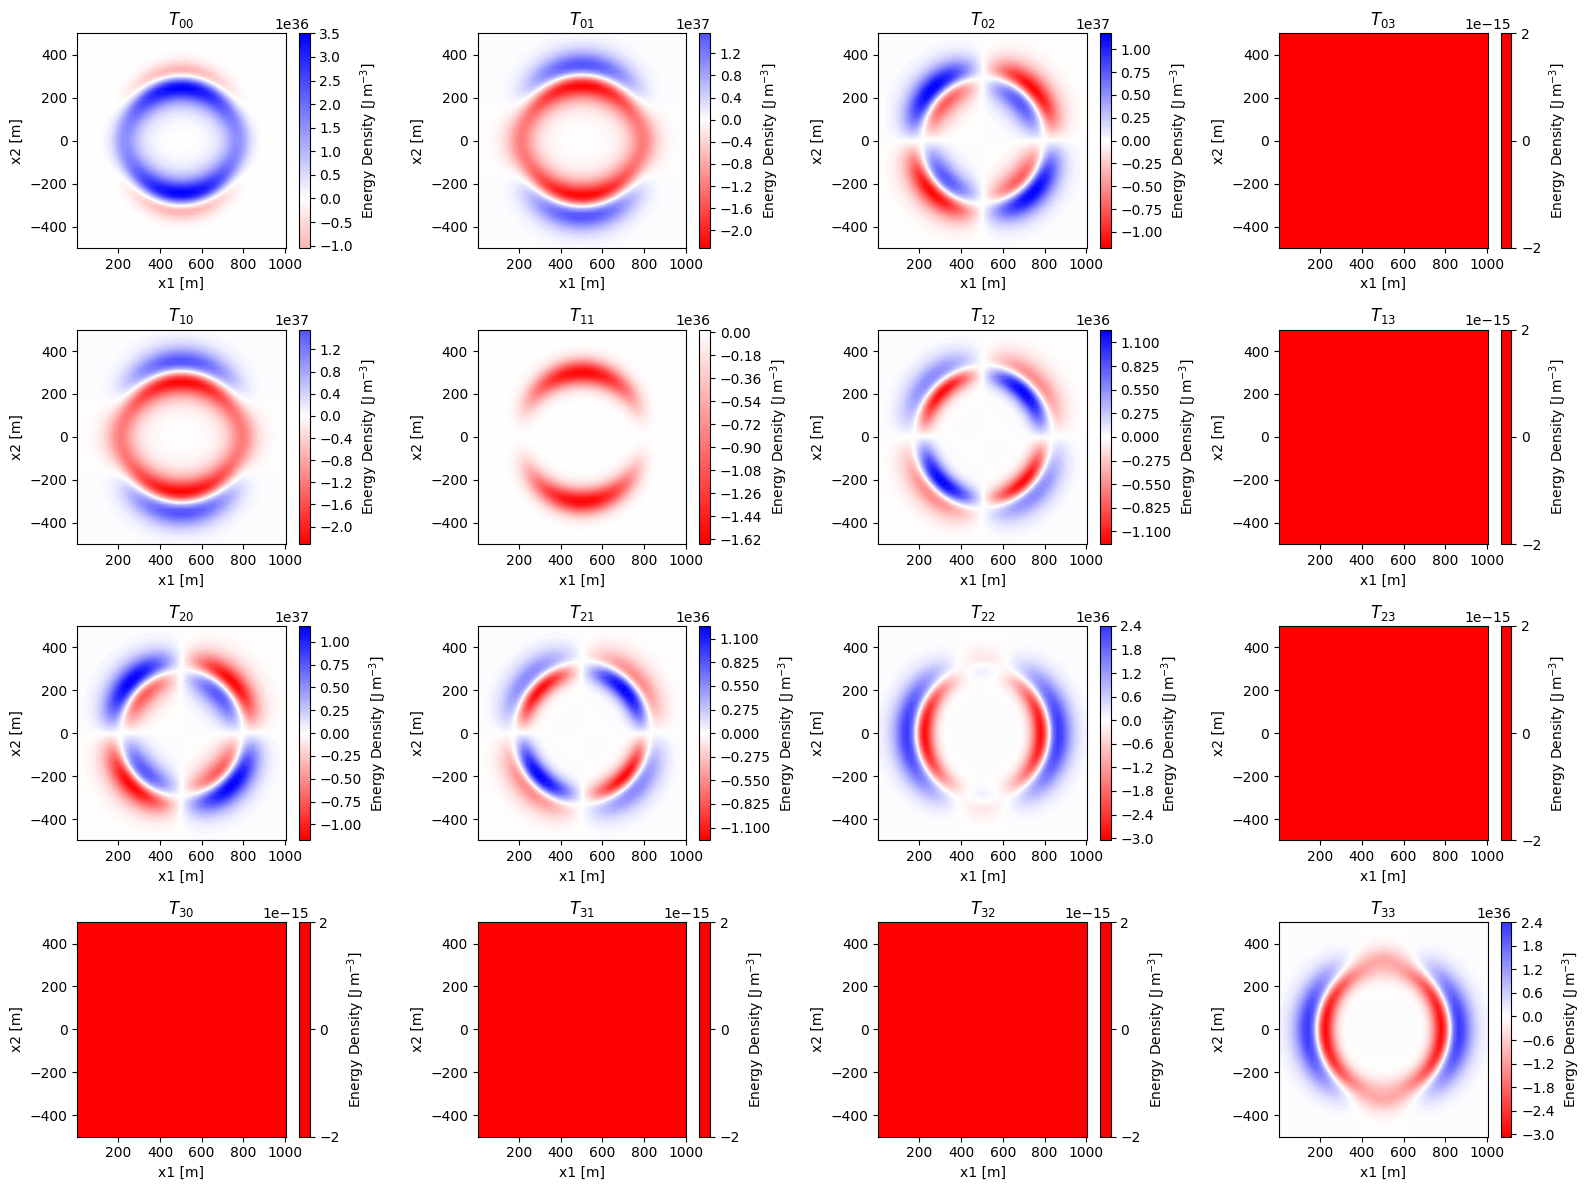

In [13]:
warp_test.display_energy_momentum_tensor_for_distant_oberver(set_z_const="auto")

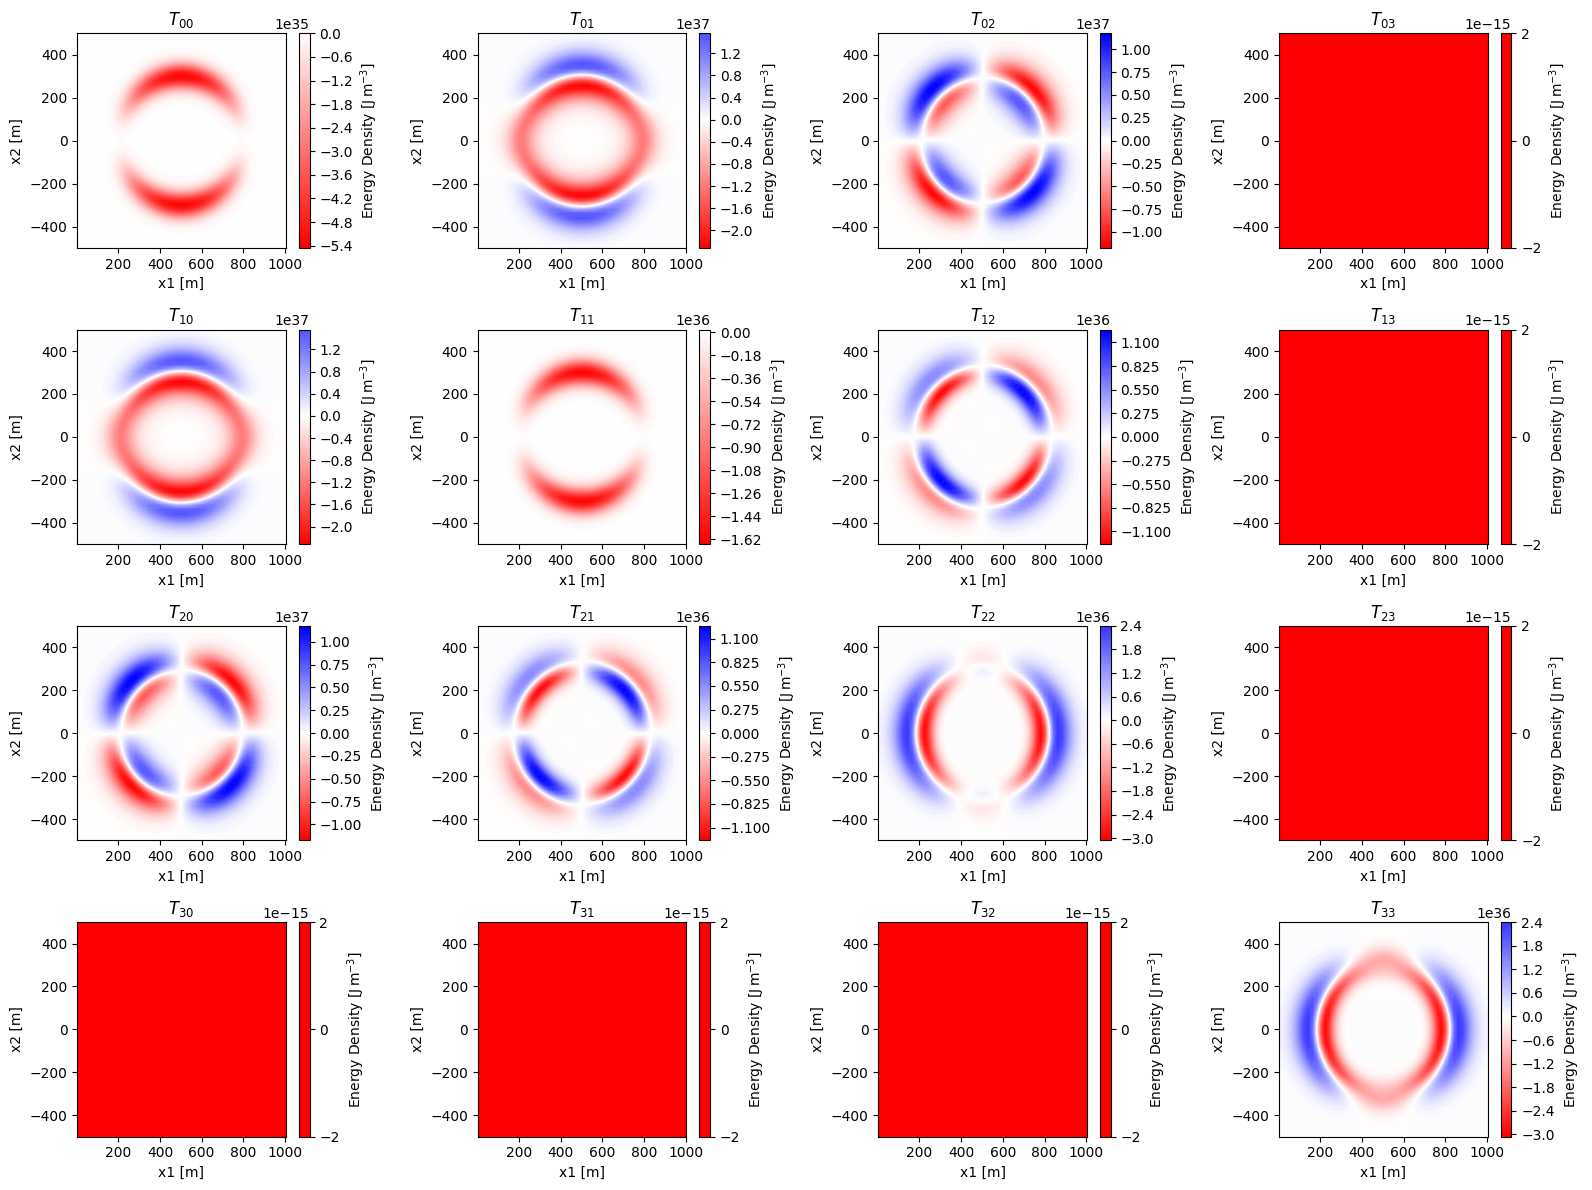

In [14]:
warp_test.display_energy_momentum_tensor_for_local_oberver(set_z_const="auto")

### Energy conditions

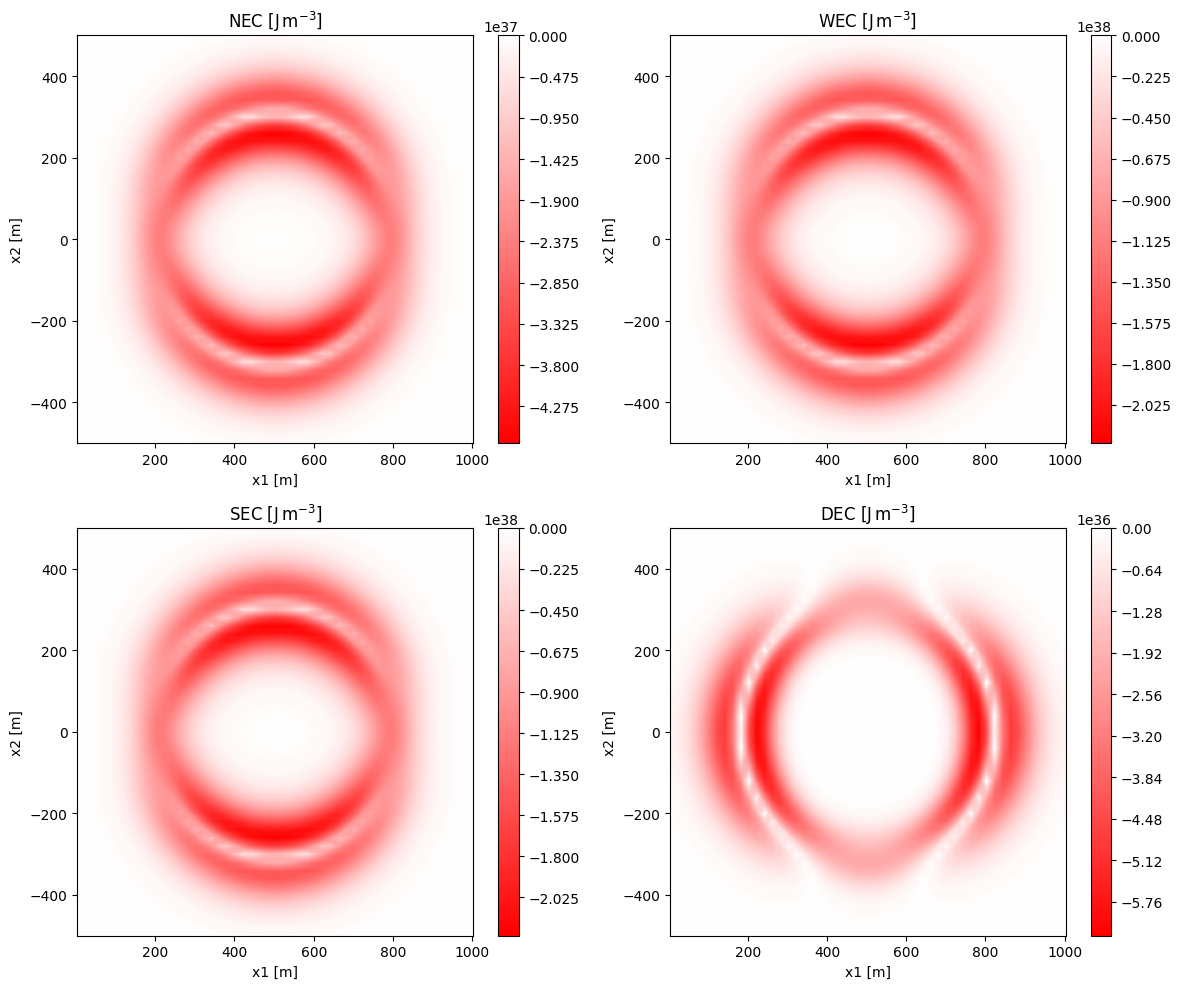

In [15]:
warp_test.compute_and_display_energy_condition(set_z_const="auto")

### Define the inverse Gamma metric and display 3 + 1 formalism variable

In [16]:
# Initialize the metric tensor g
Gamma_inverse = np.zeros((3, 3, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
Gamma_inverse[0, 0] = 1
Gamma_inverse[1, 1] = 1 
Gamma_inverse[2, 2] = 1



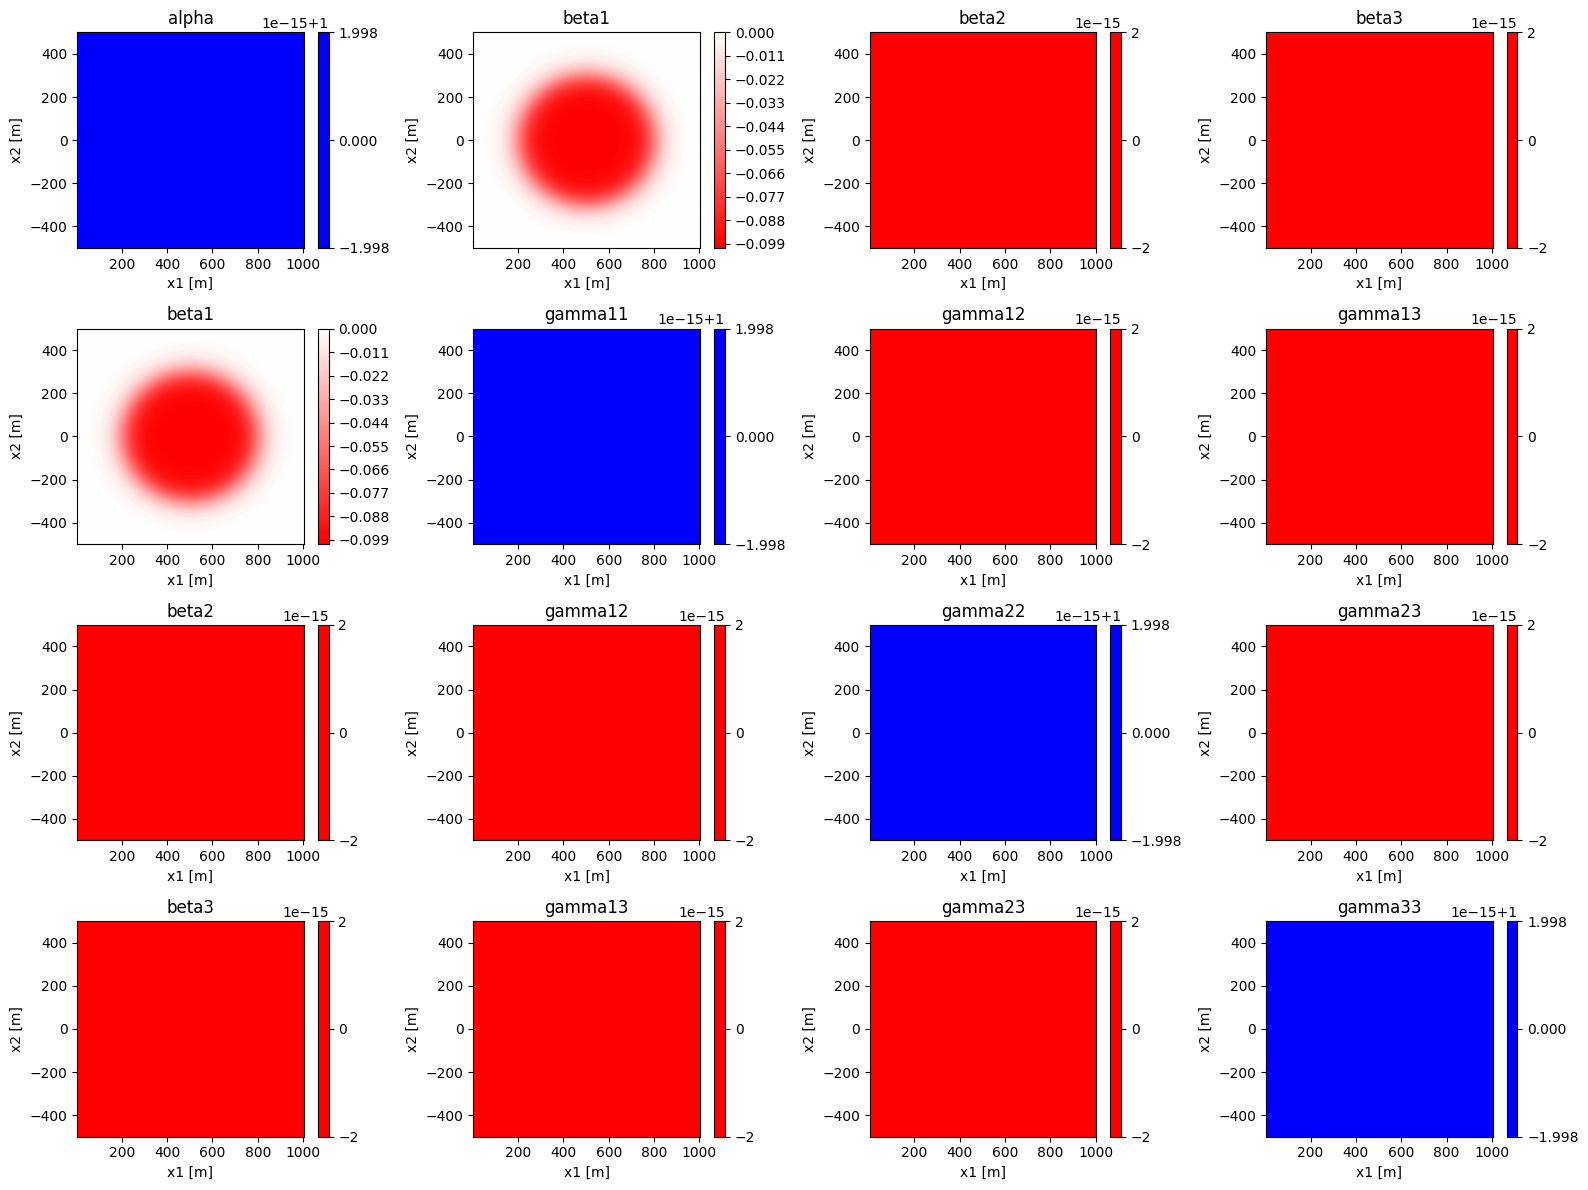

In [17]:
warp_test.display_31_metric(Gamma_inverse,set_z_const="auto")

## Van Den Broeck Metric

### Define the metric

In [18]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015*4)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))



sigma2=np.float32(0.015*4)
R_tilde=np.float32(200)
alpha=np.float32(0.5)
    
B =1 + alpha*(np.tanh(sigma2 * (r + R_tilde)) - np.tanh(sigma2 * (r - R_tilde))) / (2 * np.tanh(sigma2 * R_tilde))
  

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = f**2 * v**2 * B**2 - 1
g[0, 1] = -f * v * B**2
g[1, 0] = -f * v * B**2
g[1, 1] = B**2
g[2, 2] = B**2
g[3, 3] = B**2

### Define the inverse metric

In [19]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1
g_inv[0, 1] = -f * v
g_inv[1, 0] = -f * v
g_inv[1, 1] = 1/B**2 - f**2 * v**2
g_inv[2, 2] = 1/B**2
g_inv[3, 3] = 1/B**2

### Define the warp drive and compute

In [20]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [21]:
warp_test.compute_einstein_tensor()

Time to compute the einstein tensor: 47.6918 seconds


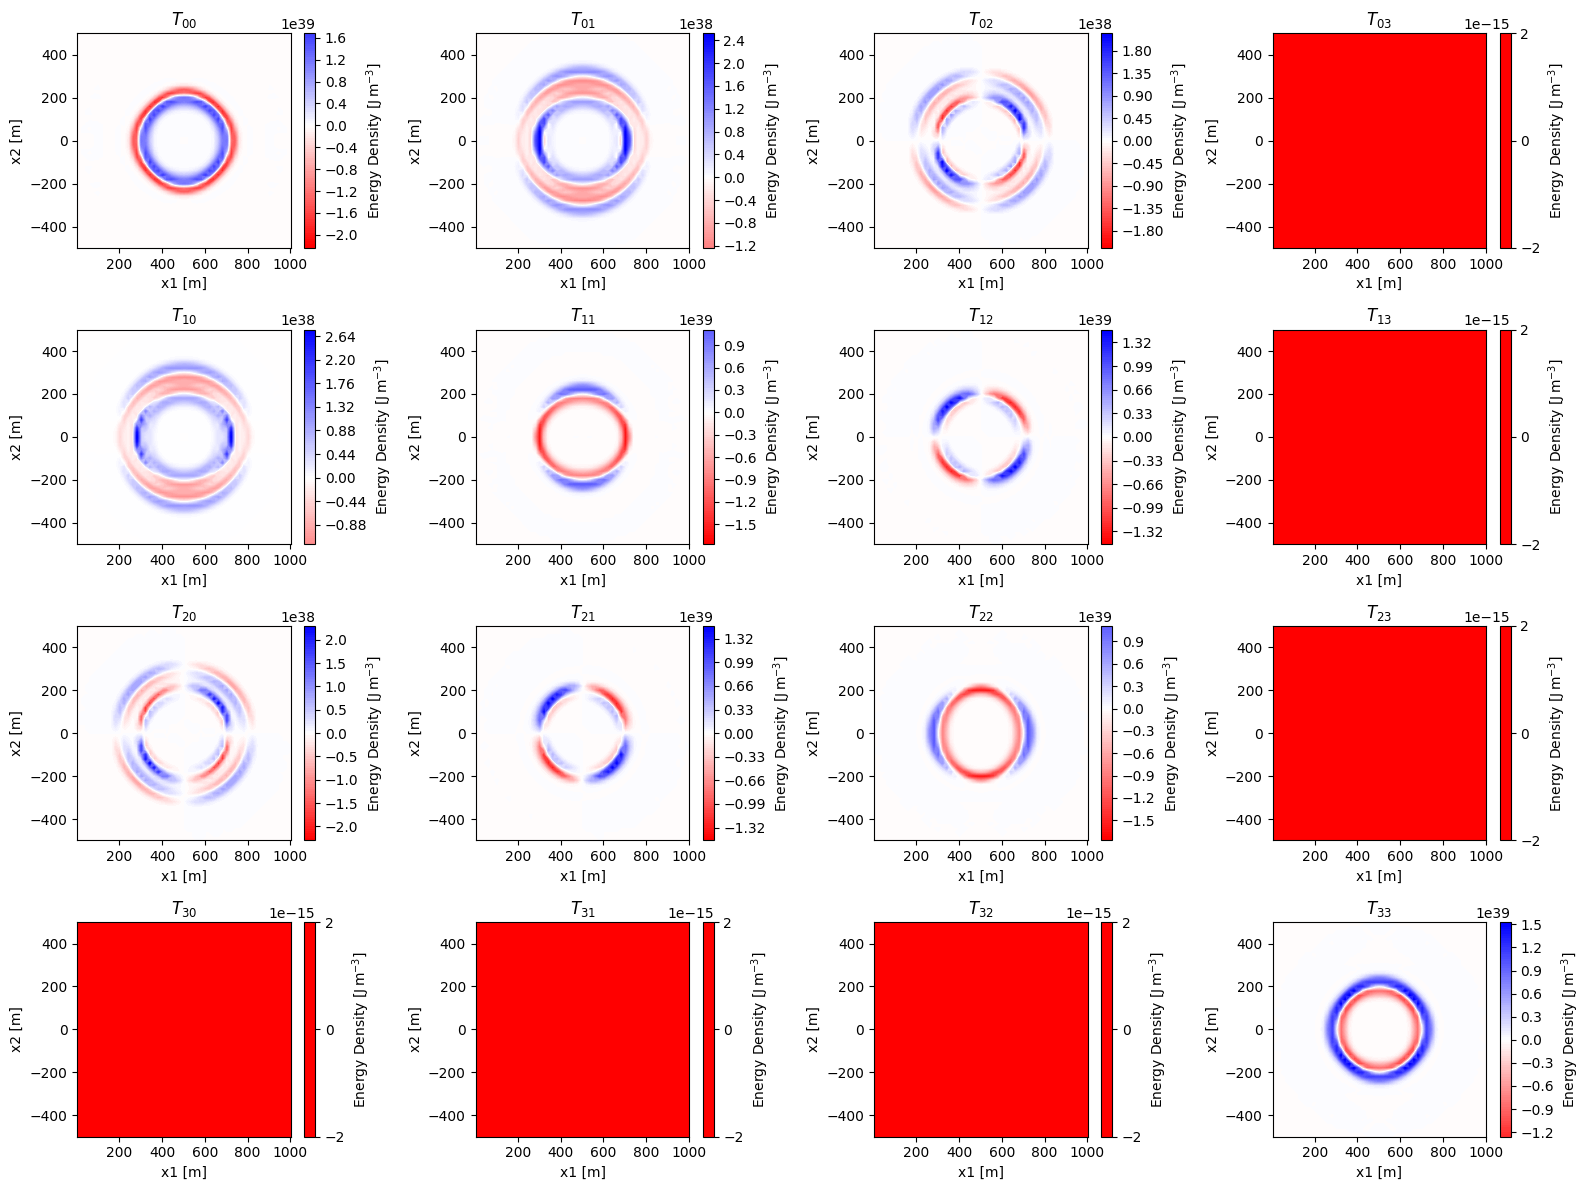

In [22]:
warp_test.display_energy_momentum_tensor_for_distant_oberver(set_z_const="auto")

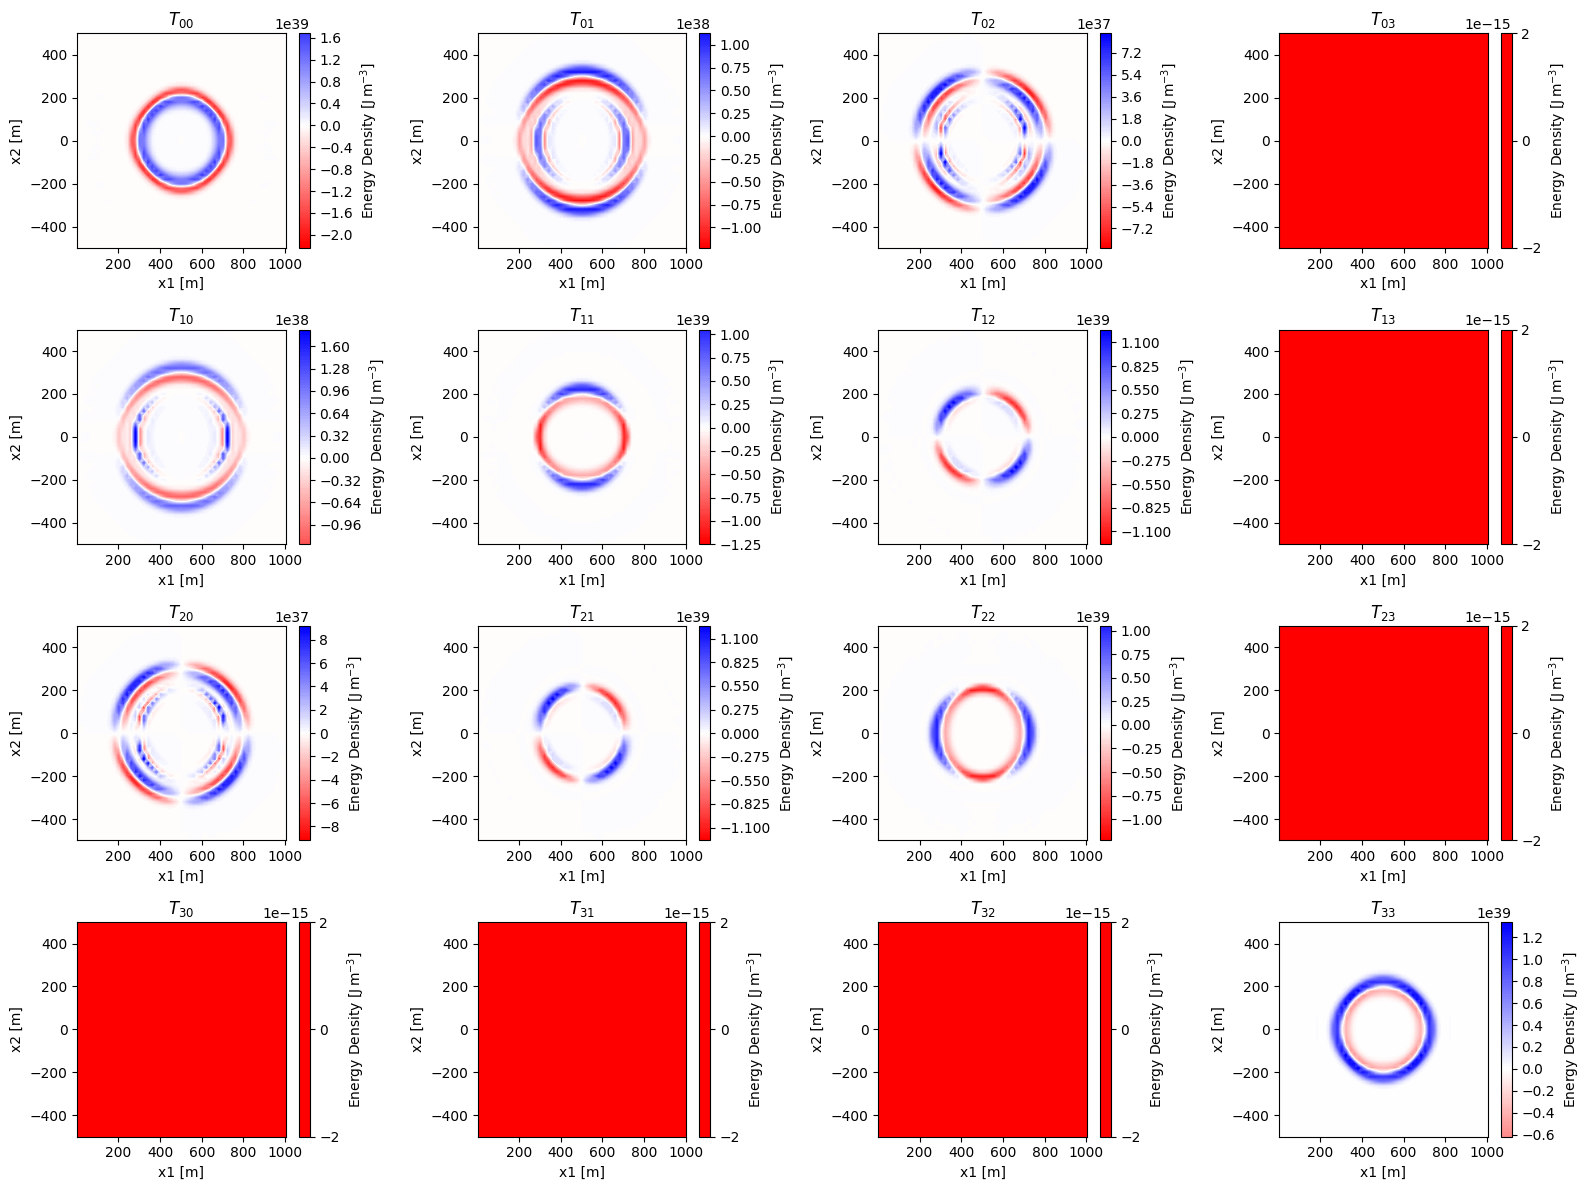

In [23]:
warp_test.display_energy_momentum_tensor_for_local_oberver(set_z_const="auto")

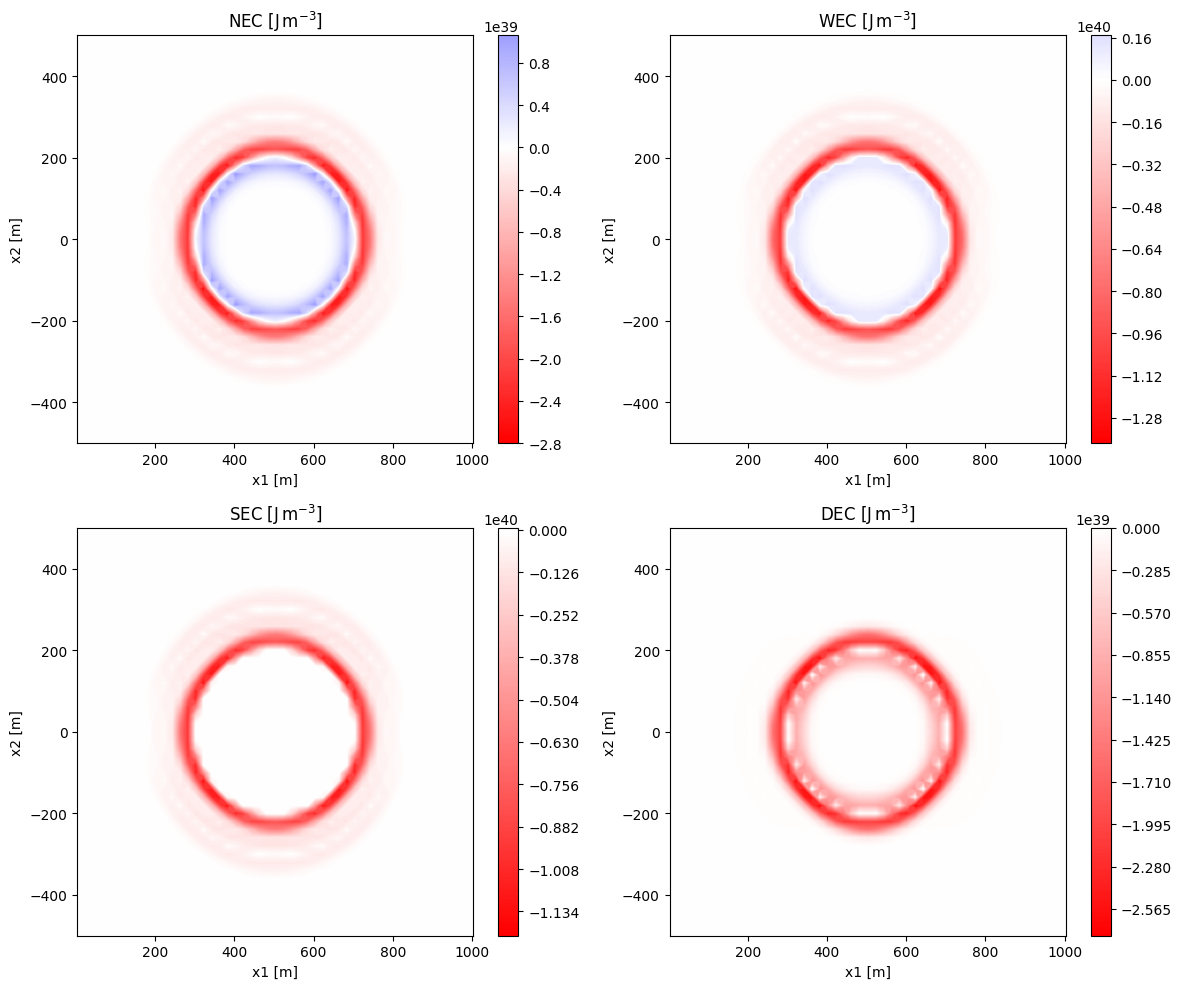

In [24]:
warp_test.compute_and_display_energy_condition(set_z_const="auto")

## Bobrick-Martire Modified Time Metric

### Define the metric

In [25]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015*4)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))


A=np.where(r < R, 0.5, 1)
# Define a smoothing kernel (averaging filter)
kernel = np.ones((5, 5, 5)) / 125


for t_ind in range(Nt):
    A[t_ind]=convolve(A[t_ind], kernel, mode='constant', cval=1)


  

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = -((1-f)+(f*A))**2+(f*v)**2
g[0, 1] = -f * v 
g[1, 0] = -f * v 
g[1, 1] = 1
g[2, 2] = 1
g[3, 3] = 1

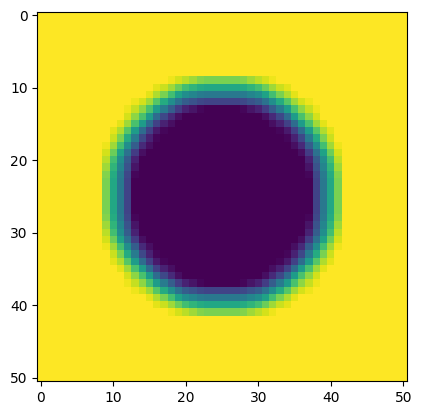

In [26]:
plt.imshow(A[25,:,:,25])

### Define the inverse metric

In [27]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1/(((1-f)+(f*A))**2)
g_inv[0, 1] = -f * v/(((1-f)+(f*A))**2)
g_inv[1, 0] = -f * v/(((1-f)+(f*A))**2)
g_inv[1, 1] = 1-(f*v)**2/(((1-f)+(f*A))**2)
g_inv[2, 2] = 1
g_inv[3, 3] = 1

### Define the warp drive and compute

In [28]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [29]:
warp_test.compute_einstein_tensor()

Time to compute the einstein tensor: 48.0238 seconds


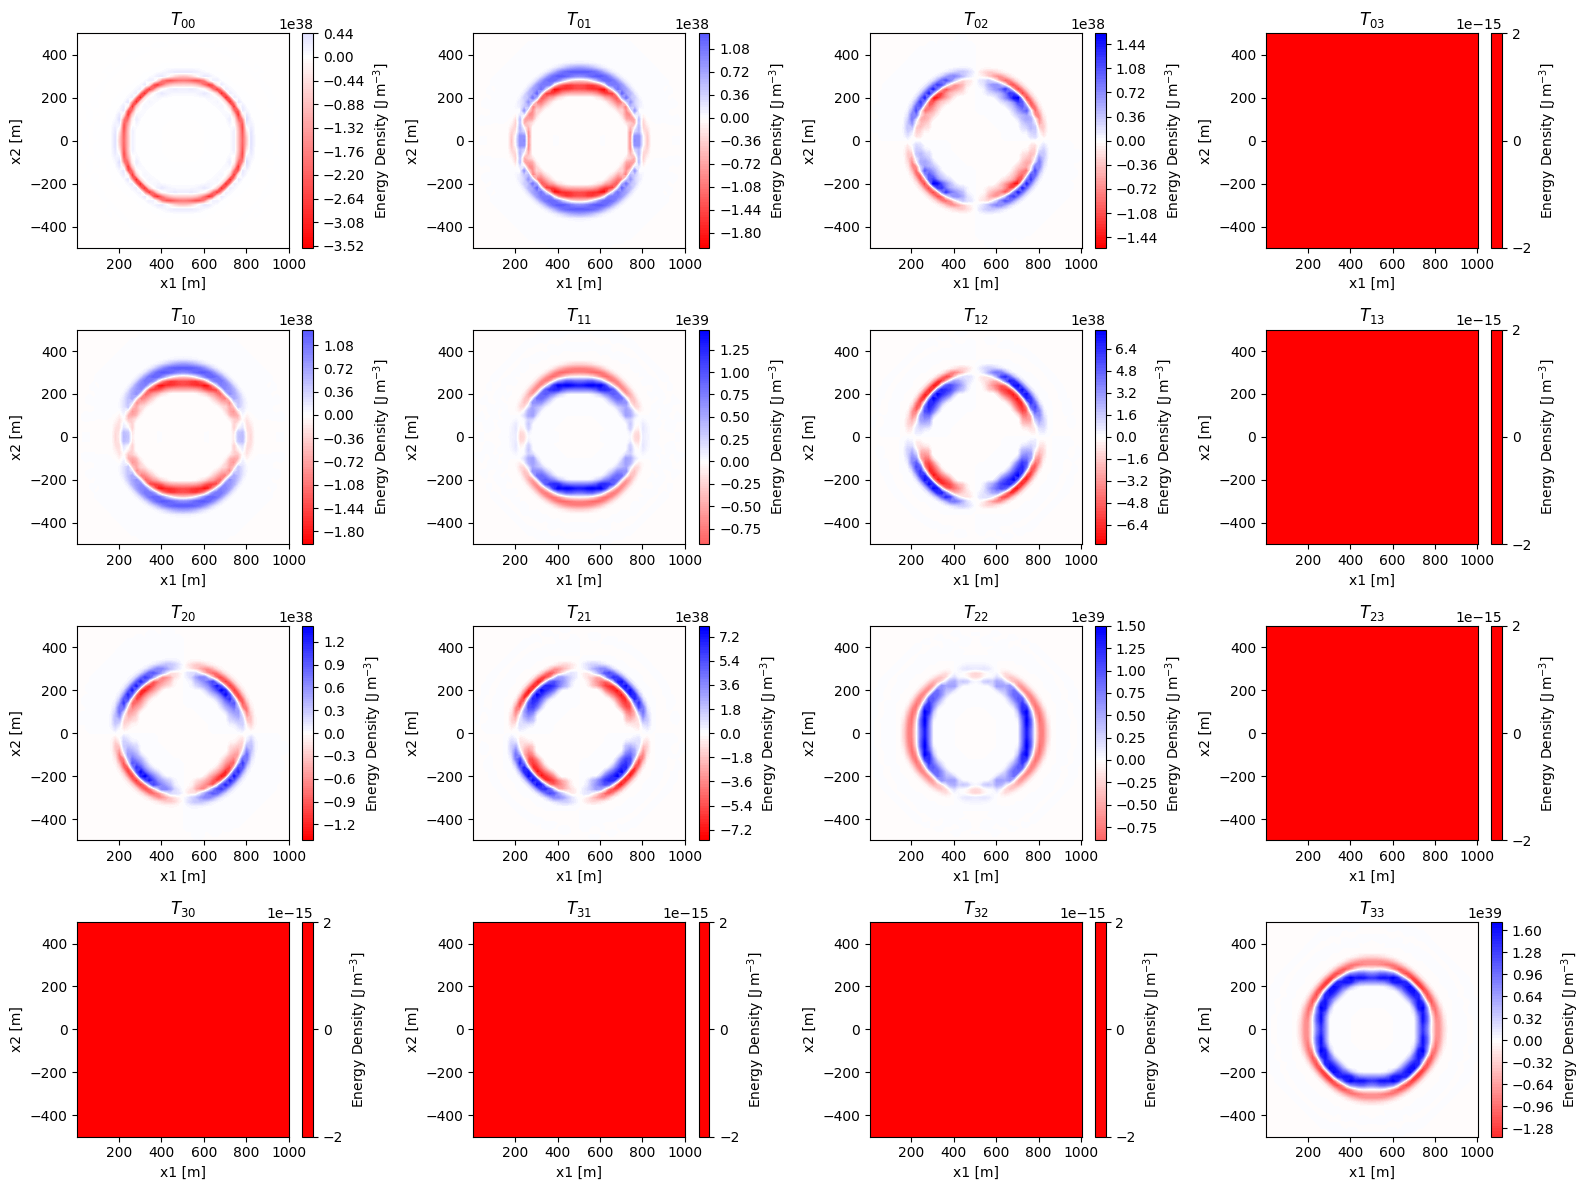

In [30]:
warp_test.display_energy_momentum_tensor_for_distant_oberver(set_z_const="auto")

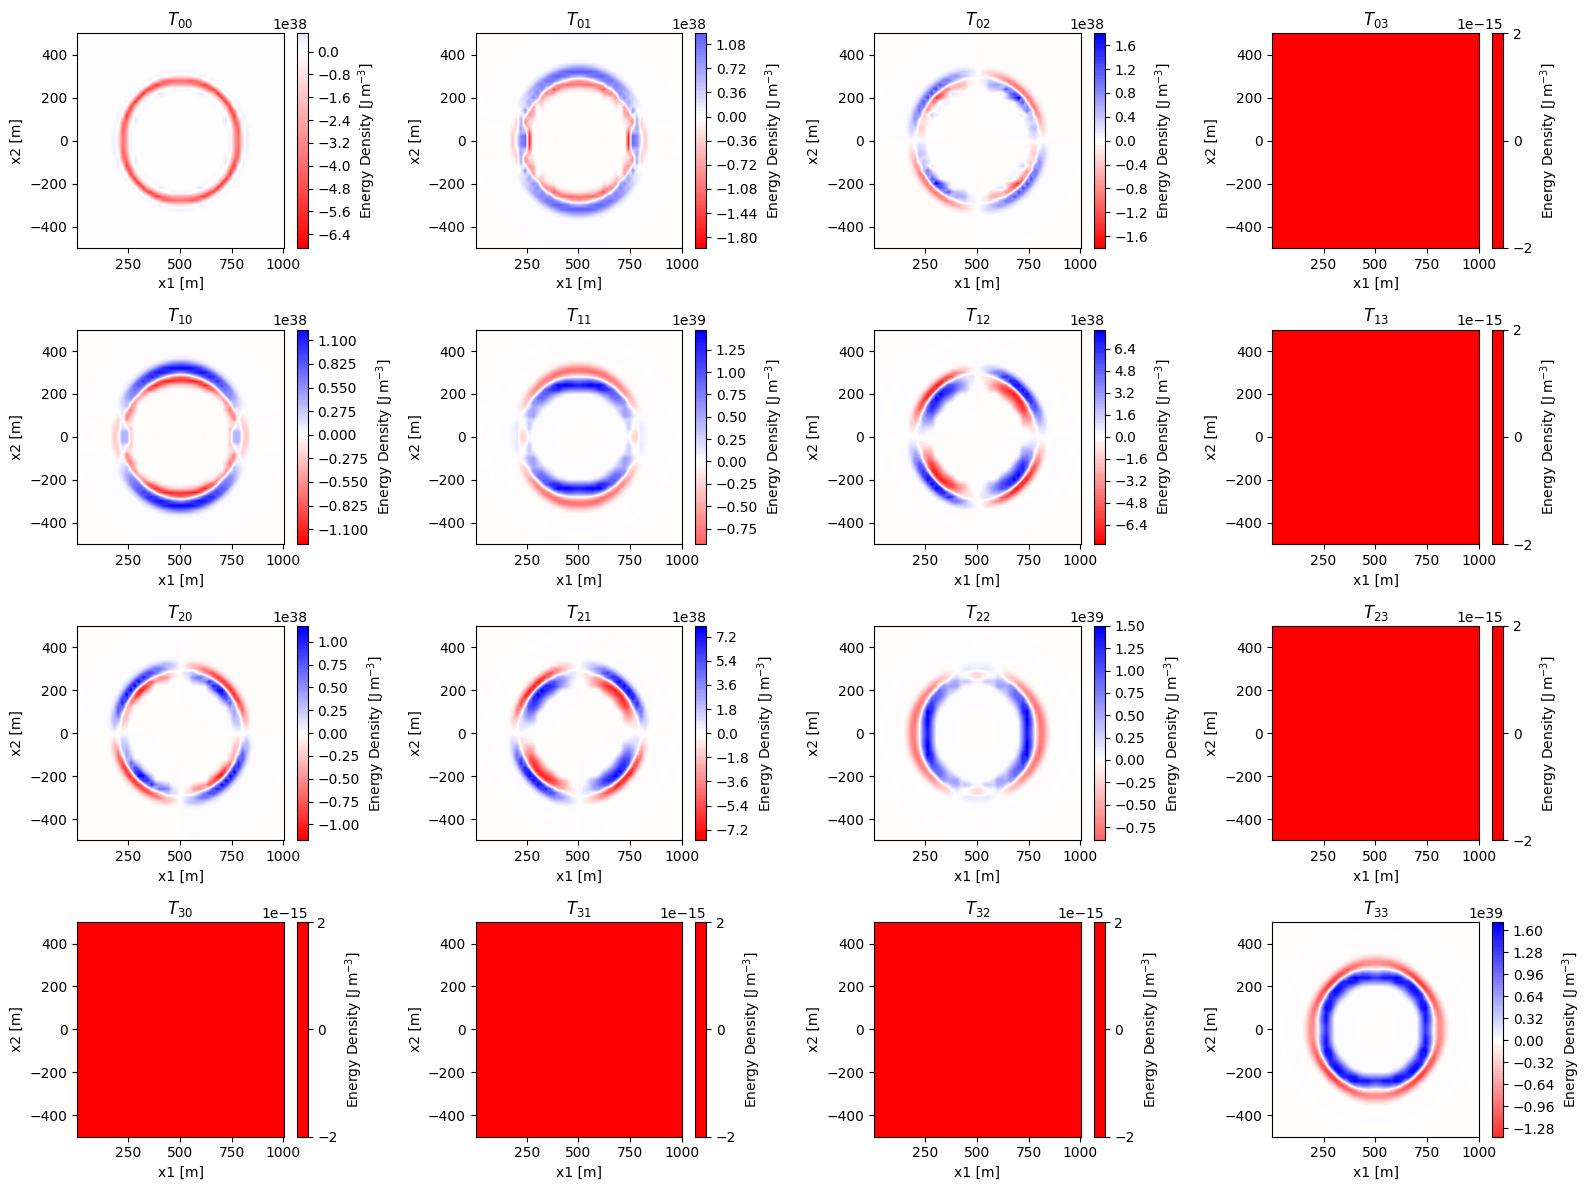

In [31]:
warp_test.display_energy_momentum_tensor_for_local_oberver(set_z_const="auto")

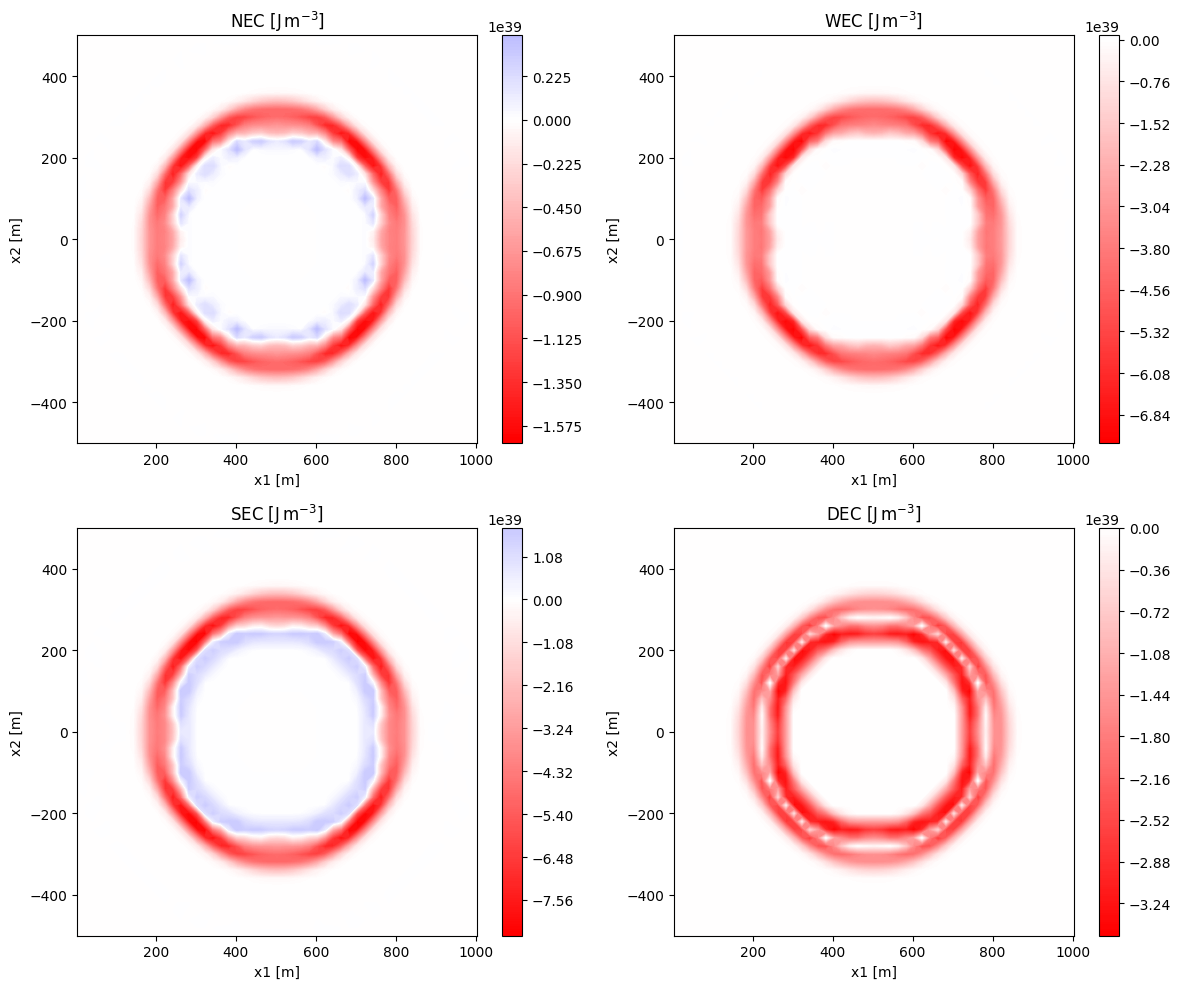

In [32]:
warp_test.compute_and_display_energy_condition(set_z_const="auto")

## Lentz-Inspired Metric

### Define the metric

In [33]:
def get_warp_factor_by_region(x_in, y_in, size_scale):
    x = x_in
    y = abs(y_in)
    WFX = 0
    WFY = 0

    # Lentz shift vector template
    if (x >= size_scale and x <= 2 * size_scale) and (x - size_scale >= y):
        WFX = -2
        WFY = 0
    elif (x > size_scale and x <= 2 * size_scale) and (x - size_scale <= y) and (-y + 3 * size_scale >= x):
        WFX = -1
        WFY = 1
    elif (x > 0 and x <= size_scale) and (x + size_scale > y) and (-y + size_scale < x):
        WFX = 0
        WFY = 1
    elif (x > 0 and x <= size_scale) and (x + size_scale <= y) and (-y + 3 * size_scale >= x):
        WFX = -0.5
        WFY = 0.5
    elif (x > -size_scale and x <= 0) and (-x + size_scale < y) and (-y + 3 * size_scale >= -x):
        WFX = 0.5
        WFY = 0.5
    elif (x > -size_scale and x <= 0) and (x + size_scale <= y) and (-y + size_scale >= x):
        WFX = 1
        WFY = 0
    elif (x >= -size_scale and x <= size_scale) and (x + size_scale > y):
        WFX = 1
        WFY = 0

    WFY = (1 if y_in >= 0 else -1) * WFY

    return WFX, WFY

In [34]:
# Define parameters directly as float16
v, size_scale = np.float32(0.1), np.float32(140)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')


In [35]:
WFX=np.zeros((N,N,N,N))
WFY=np.zeros((N,N,N,N))

for i in tqdm(range(N)):
    for j in range(N):
        for k in range(N):
            for l in range(N):
                WFX[i,j,k,l],WFY[i,j,k,l]=get_warp_factor_by_region(x[j]-v*t[i],y[k],size_scale)
                


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:14<00:00,  1.46s/it]


In [36]:
# Define a smoothing kernel (averaging filter)
kernel = np.ones((3, 3)) / 9


#smoother
for i in tqdm(range(N)): #t
    for l in range(N): #z
        WFX[i,:,:,l]=convolve(WFX[i,:,:,l], kernel, mode='constant', cval=0)
        WFY[i,:,:,l]=convolve(WFY[i,:,:,l], kernel, mode='constant', cval=0)
                


100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 170.11it/s]


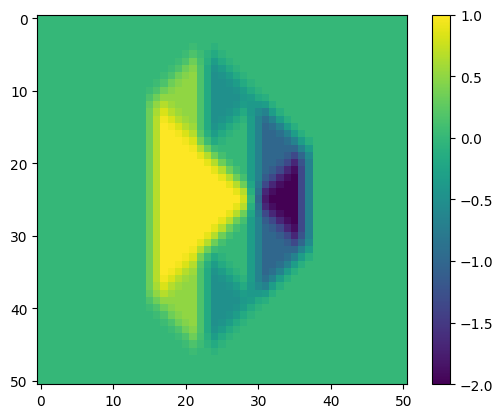

In [37]:
plt.imshow(WFX[0,:,:,2].T)
plt.colorbar()

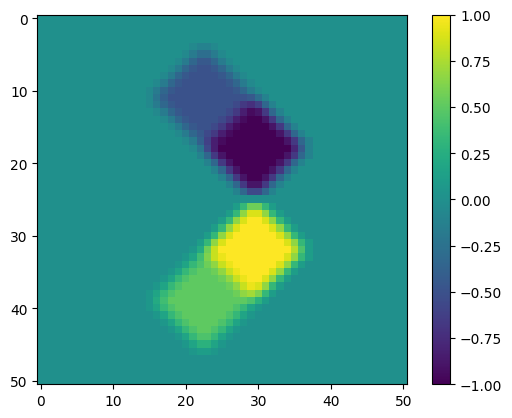

In [38]:
plt.imshow(WFY[0,:,:,8].T)
plt.colorbar()

In [39]:
# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = -1 + (v*WFX)**2 + (v*WFY)**2
g[0, 1] = -v*WFX
g[1, 0] = -v*WFX
g[0, 2] = v*WFY
g[2, 0] = v*WFY
g[1, 1] = 1
g[2, 2] = 1
g[3, 3] = 1

### Define the inverse metric

In [40]:
inverse_slab_g=np.zeros((4, 4, Nt, Nx, Ny))


for i in tqdm(range(N)):
    for j in range(N):
        for k in  range(N):
            inverse_slab_g[:,:,i,j,k] = np.linalg.inv(g[:,:,i,j,k,12])

#g_inv=np.transpose(np.tile(inverse_slab_g[..., np.newaxis, np.newaxis], (1, 1, 1, 1, N, N)),axes=(0,1,4,2,3,5))
g_inv=np.tile(inverse_slab_g[..., np.newaxis], (1, 1, 1, 1, 1, N))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  6.07it/s]


In [41]:
if True: #small test just to be sure
    print(g_inv.shape)
    test = np.einsum('ij...,jk...->ik...', g_inv,g)
    print(np.max(np.abs(test),axis=(2,3,4,5)))

(4, 4, 51, 51, 51, 51)
[[1.00000003e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.57103391e-09 1.00000003e+00 5.21540644e-10 0.00000000e+00]
 [4.58968852e-09 5.21540644e-10 1.00000003e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Define the warp drive and compute

In [42]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [43]:
warp_test.compute_einstein_tensor()

Time to compute the einstein tensor: 50.6811 seconds


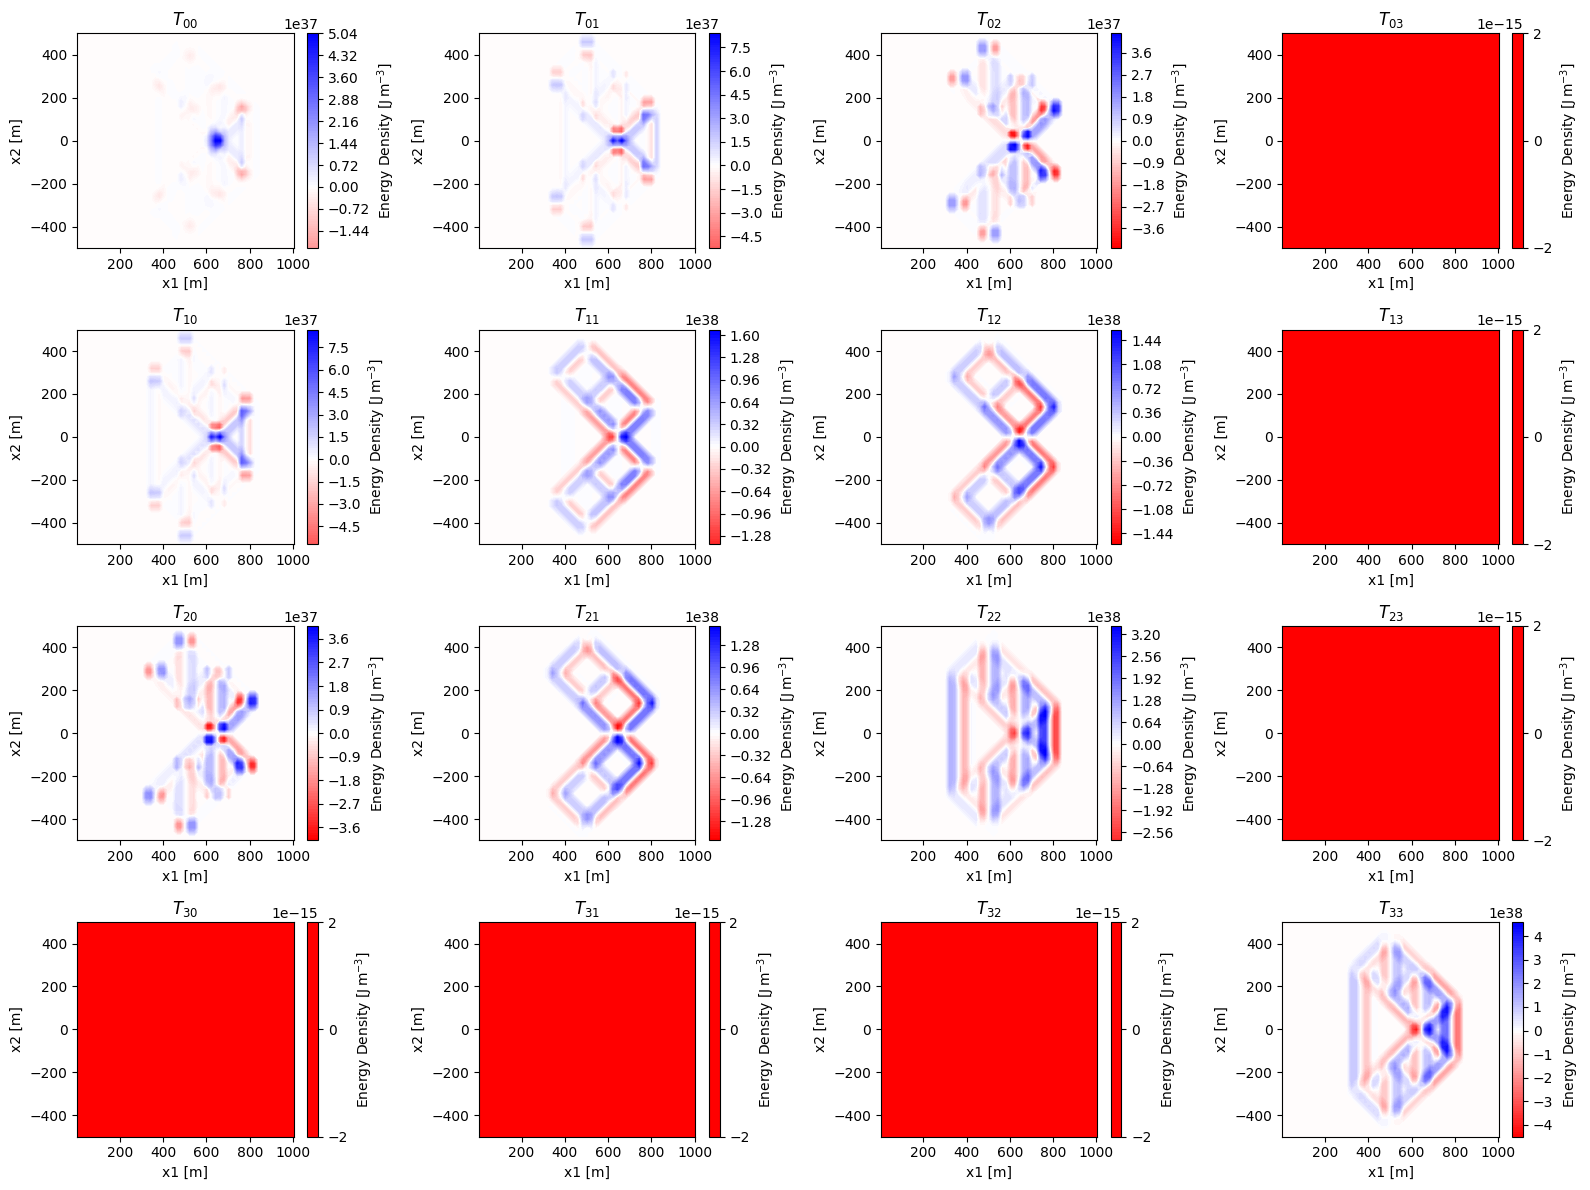

In [44]:
warp_test.display_energy_momentum_tensor_for_distant_oberver(set_z_const="auto")

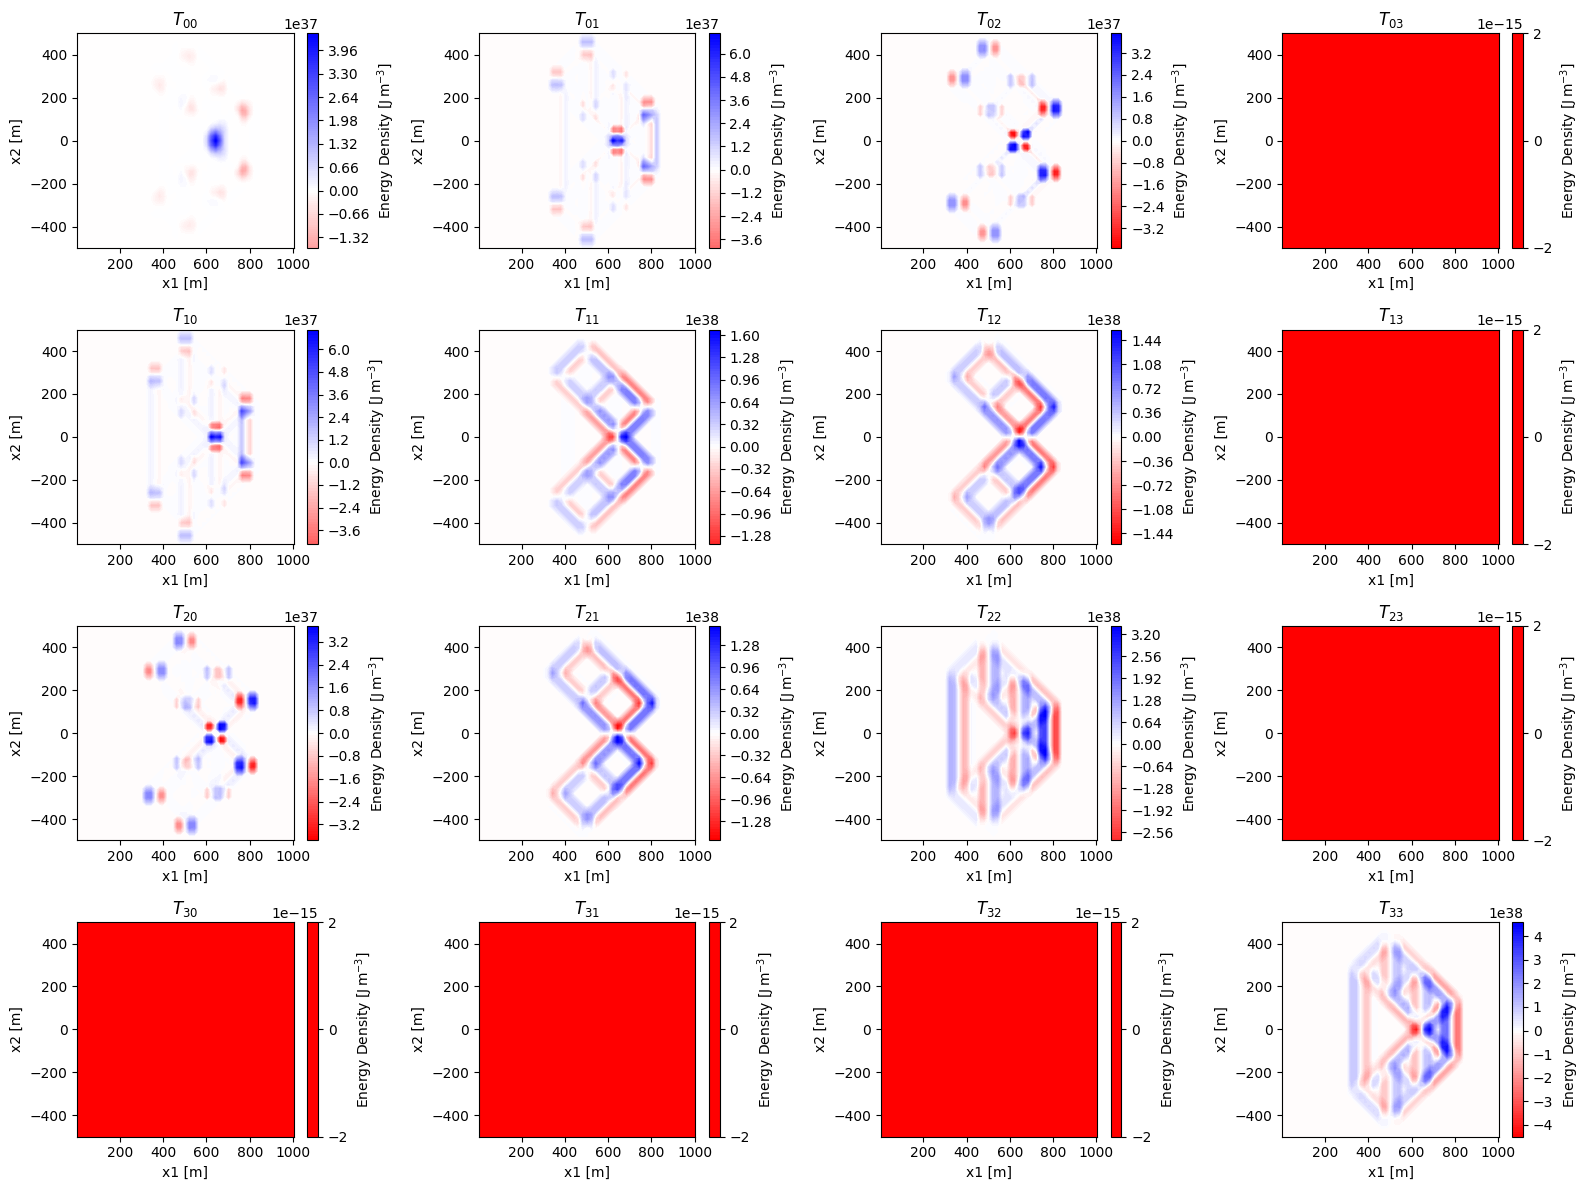

In [45]:
warp_test.display_energy_momentum_tensor_for_local_oberver(set_z_const="auto")

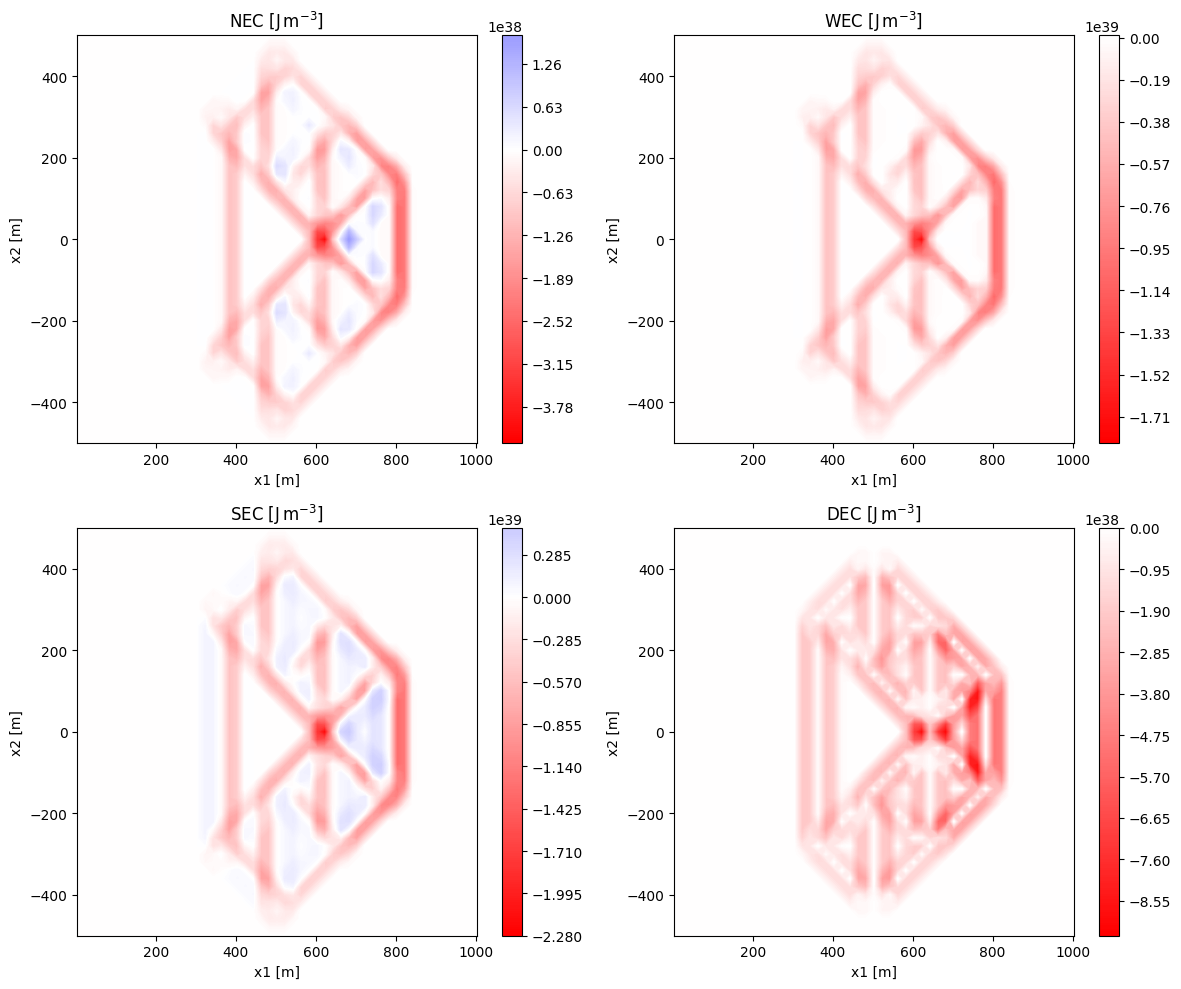

In [46]:
warp_test.compute_and_display_energy_condition(set_z_const="auto")